Note: This Jupyter Notebook created within **Google Colab** environment.

# Problem Statement

At MainGames we are committed to help streamers increase their revenues by leveraging the rich source of streaming data to provide actionable insights. In this problem, we want to learn whether certain features of streamers will make them more or less likely to receive stars from their audience, in this case **PaidStarPerWatchedHour** is our dependent variable (target variable).

# Dataset Description

This dataset consists of more than 600 streamers (Indonesia, Vietnam, Philippines). **Each row represents data of one unique streamer**. There are different sets of facial features extracted using an AI tool (Self_Esteem_, Character_Facet_, Personal_Values_Facet_, Temperament_), in addition to Gender, Game, Country, Total Follower, and the role they play in the game (e.g., Role_Director). 

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 8.2 MB/s 


In [ ]:
!pip install statsmodels==0.13.0

     |████████████████████████████████| 9.8 MB 6.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import shap
import networkx as nx
import pickle
from statsmodels.stats.descriptivestats import describe
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, silhouette_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.ticker import PercentFormatter
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey

# Initial Data Preparation

In [ ]:
# Import the data
# Specify the directory based on the location of your dataset
df = pd.read_csv("/content/drive/MyDrive/Personal Project/MainGames Case Problem/Dataset.csv", na_values = ["-"])
df

# I added the "-" for detecting missing values because the data consist of those "-" character

,Unnamed: 0,Country,Gender,Game,Total Follower,Broadcast Hours,PaidStarPerWatchedHour,Character_Facet_Cont_Rigidity,Character_Facet_Cont_AchievementStriving,Personal_Values_Facet_Cont_Hedonism,Character_Facet_Cont_Dutifulness,Character_Cont_Conscientiousness,Character_Facet_Cont_Sympathy,Personal_Values_Facet_Cont_UniversalismTolerance,Temperament_Choleric,Self_Esteem_Cont_SEDiscrepancyResponsibility,Character_Facet_Cont_ArtisticInterests,Temperament_Sanguine,Character_Facet_Cont_Friendliness,Temperament_Diligent,Self_Esteem_Cont_SELevel,Character_Cont_Extraversion,Role_Director,Character_Facet_Cont_SelfConsciousness,Temperament_Energetic,Character_Facet_Cont_Adventurousness,Role_Craftsman,Self_Esteem_Cont_SELevelResponsibility,Self_Esteem_Cont_SEAspirationResponsibility,Role_Toastmaster,Personal_Values_Facet_Cont_PowerDominance,Role_Marshal,Self_Esteem_Cont_SELevelAchievements,Self_Esteem_Cont_SEDiscrepancySociability,Personal_Values_Cont_SelfEnhancement,Self_Esteem_Cont_SEAspiration,Role_Supplier,Character_Facet_Cont_Activity,Temperament_Stable,Personal_Values_Facet_Cont_PowerResources,...,Personal_Values_Facet_Cont_SecurityPersonal,Personal_Values_Facet_Cont_UniversalismConcern,Role_Advisor,Self_Esteem_Cont_SELevelOriginality,Role_Analyst,Personal_Values_Cont_SelfTranscendence,Personal_Values_Facet_Cont_Achievement,Character_Facet_Cont_Trust,Temperament_Unstable,Character_Cont_Agreeableness,Role_Inventor,Personal_Values_Facet_Cont_BenevolenceCaring,Personal_Values_Facet_Cont_BenevolenceDependability,Character_Facet_Cont_Vulnerability,Character_Facet_Cont_ExcitementSeeking,Role_Designer,Role_Deputy,Personal_Values_Cont_OpennessToChange,PaidStarPerWatchedHour.1,Character_Facet_Cont_Morality,Character_Facet_Cont_Depression,Role_Strategist,Role_Inspector,Self_Esteem_Cont_SEAspirationAppearance,Character_Facet_Cont_SelfDiscipline,Self_Esteem_Cont_SEDiscrepancyIntelligence,Role_Companion,Character_Facet_Cont_Cooperation,Role_Commander,Role_Activist,Personal_Values_Facet_Cont_UniversalismNature,Role_Charismatic,Personal_Values_Facet_Cont_Tradition,Self_Esteem_Cont_SELevelAppearance,Character_Facet_Cont_Assertiveness,Character_Facet_Cont_Cautiousness,Role_Curator,Personal_Values_Cont_Conservation,Self_Esteem_Cont_SELevelIntelligence,Temperament_Centric
0,0,ID,Male,MLBB,96751,104,0.004113,0.663442,0.718679,0.288008,0.471456,0.522711,0.337836,0.554134,0.00,0.496688,0.504059,0.25,0.494384,0.125,0.462912,0.474577,0.679339,0.471482,0.125,0.544957,0.453882,0.679427,0.721495,0.530887,0.356304,0.620860,0.605858,0.473335,0.303076,0.881936,0.509514,0.691145,0.750,0.317289,...,0.353928,0.477637,0.577660,0.728769,0.627180,0.275763,0.322608,0.450080,0.500,0.467756,0.705475,0.543155,0.244511,0.686694,0.554406,0.533952,0.516859,0.303909,0.004113,0.553544,0.771031,0.783868,0.670467,0.648751,0.518061,0.473907,0.541372,0.352032,0.449807,0.514417,0.523116,0.408444,0.318747,0.684412,0.494384,0.751974,0.524306,0.299052,0.803920,0.625
1,1,ID,Male,8 Ball Pool,4781,174,0.002855,0.543255,0.427887,0.430609,0.493514,0.348513,0.408481,0.610872,0.00,0.557879,0.577758,0.50,0.468738,0.250,0.386516,0.445183,0.381432,0.352964,0.000,0.604113,0.325222,0.743407,0.534425,0.349459,0.341675,0.486200,0.490160,0.579283,0.298714,0.860851,0.098237,0.554197,0.625,0.317427,...,0.425649,0.456436,0.239550,0.771001,0.403616,0.264248,0.333644,0.504510,0.125,0.225692,0.718745,0.460678,0.276966,0.627786,0.511837,0.488030,0.263292,0.309062,0.002855,0.352700,0.462166,0.549318,0.397981,0.690168,0.442303,0.482889,0.230455,0.401419,0.277163,0.286003,0.444493,0.407624,0.382594,0.635493,0.468738,0.571198,0.100202,0.304527,0.751291,0.125
2,2,ID,Female,Free Fire - Battlegrounds,68246,83,0.003007,0.527279,0.399873,0.753009,0.472405,0.376854,0.518602,0.579433,0.50,0.395199,0.594752,0.00,0.413872,0.500,0.568077,0.322573,0.305979,0.750039,0.000,0.657773,0.784232,0.555626,0.568014,0.555618,0.362791,0.177483,0.189999,0.510046,0.231113,0.805830,0.360728,0.546109,0.000,0.216132,...,0.355100,0.69860

There are 631 rows with 127 columns in the data set with **PaidStarPerWatchedHour** as the target variable. As you can see that the first column called "Unnamed: 0" is unnecessary, so we could drop it from the data set.

In [ ]:
# Drop the first column from the data set
df = df.drop("Unnamed: 0", axis = 1)
df.head()

,Country,Gender,Game,Total Follower,Broadcast Hours,PaidStarPerWatchedHour,Character_Facet_Cont_Rigidity,Character_Facet_Cont_AchievementStriving,Personal_Values_Facet_Cont_Hedonism,Character_Facet_Cont_Dutifulness,Character_Cont_Conscientiousness,Character_Facet_Cont_Sympathy,Personal_Values_Facet_Cont_UniversalismTolerance,Temperament_Choleric,Self_Esteem_Cont_SEDiscrepancyResponsibility,Character_Facet_Cont_ArtisticInterests,Temperament_Sanguine,Character_Facet_Cont_Friendliness,Temperament_Diligent,Self_Esteem_Cont_SELevel,Character_Cont_Extraversion,Role_Director,Character_Facet_Cont_SelfConsciousness,Temperament_Energetic,Character_Facet_Cont_Adventurousness,Role_Craftsman,Self_Esteem_Cont_SELevelResponsibility,Self_Esteem_Cont_SEAspirationResponsibility,Role_Toastmaster,Personal_Values_Facet_Cont_PowerDominance,Role_Marshal,Self_Esteem_Cont_SELevelAchievements,Self_Esteem_Cont_SEDiscrepancySociability,Personal_Values_Cont_SelfEnhancement,Self_Esteem_Cont_SEAspiration,Role_Supplier,Character_Facet_Cont_Activity,Temperament_Stable,Personal_Values_Facet_Cont_PowerResources,Self_Esteem_Cont_SEDiscrepancyAchievements,...,Personal_Values_Facet_Cont_SecurityPersonal,Personal_Values_Facet_Cont_UniversalismConcern,Role_Advisor,Self_Esteem_Cont_SELevelOriginality,Role_Analyst,Personal_Values_Cont_SelfTranscendence,Personal_Values_Facet_Cont_Achievement,Character_Facet_Cont_Trust,Temperament_Unstable,Character_Cont_Agreeableness,Role_Inventor,Personal_Values_Facet_Cont_BenevolenceCaring,Personal_Values_Facet_Cont_BenevolenceDependability,Character_Facet_Cont_Vulnerability,Character_Facet_Cont_ExcitementSeeking,Role_Designer,Role_Deputy,Personal_Values_Cont_OpennessToChange,PaidStarPerWatchedHour.1,Character_Facet_Cont_Morality,Character_Facet_Cont_Depression,Role_Strategist,Role_Inspector,Self_Esteem_Cont_SEAspirationAppearance,Character_Facet_Cont_SelfDiscipline,Self_Esteem_Cont_SEDiscrepancyIntelligence,Role_Companion,Character_Facet_Cont_Cooperation,Role_Commander,Role_Activist,Personal_Values_Facet_Cont_UniversalismNature,Role_Charismatic,Personal_Values_Facet_Cont_Tradition,Self_Esteem_Cont_SELevelAppearance,Character_Facet_Cont_Assertiveness,Character_Facet_Cont_Cautiousness,Role_Curator,Personal_Values_Cont_Conservation,Self_Esteem_Cont_SELevelIntelligence,Temperament_Centric
0,ID,Male,MLBB,96751,104,0.004113,0.663442,0.718679,0.288008,0.471456,0.522711,0.337836,0.554134,0.0,0.496688,0.504059,0.25,0.494384,0.125,0.462912,0.474577,0.679339,0.471482,0.125,0.544957,0.453882,0.679427,0.721495,0.530887,0.356304,0.620860,0.605858,0.473335,0.303076,0.881936,0.509514,0.691145,0.750,0.317289,0.544263,...,0.353928,0.477637,0.577660,0.728769,0.627180,0.275763,0.322608,0.450080,0.500,0.467756,0.705475,0.543155,0.244511,0.686694,0.554406,0.533952,0.516859,0.303909,0.004113,0.553544,0.771031,0.783868,0.670467,0.648751,0.518061,0.473907,0.541372,0.352032,0.449807,0.514417,0.523116,0.408444,0.318747,0.684412,0.494384,0.751974,0.524306,0.299052,0.803920,0.625
1,ID,Male,8 Ball Pool,4781,174,0.002855,0.543255,0.427887,0.430609,0.493514,0.348513,0.408481,0.610872,0.0,0.557879,0.577758,0.50,0.468738,0.250,0.386516,0.445183,0.381432,0.352964,0.000,0.604113,0.325222,0.743407,0.534425,0.349459,0.341675,0.486200,0.490160,0.579283,0.298714,0.860851,0.098237,0.554197,0.625,0.317427,0.583342,...,0.425649,0.456436,0.239550,0.771001,0.403616,0.264248,0.333644,0.504510,0.125,0.225692,0.718745,0.460678,0.276966,0.627786,0.511837,0.488030,0.263292,0.309062,0.002855,0.352700,0.462166,0.549318,0.397981,0.690168,0.442303,0.482889,0.230455,0.401419,0.277163,0.286003,0.444493,0.407624,0.382594,0.635493,0.468738,0.571198,0.100202,0.304527,0.751291,0.125
2,ID,Female,Free Fire - Battlegrounds,68246,83,0.003007,0.527279,0.399873,0.753009,0.472405,0.376854,0.518602,0.579433,0.5,0.395199,0.594752,0.00,0.413872,0.500,0.568077,0.322573,0.305979,0.750039,0.000,0.657773,0.784232,0.555626,0.568014,0.555618,0.362791,0.177483,0.189999,0.510046,0.231113,0.805830,0.360728,0.5

In [ ]:
# Check for missing values
temp = pd.DataFrame(df.isna().sum())
temp.columns = ["Count of Missing Values"]
temp.iloc[temp["Count of Missing Values"].values > 0, :]

,Count of Missing Values
Gender,3
Game,7
Total Follower,3
PaidStarPerWatchedHour,2
PaidStarPerWatchedHour.1,2


From there we can see that the number of rows that contains missing values is so small. Plus, there is an anomaly that PaidStarPerWatchedHour has two columns that identical.

In [ ]:
# Check if those two columns are the same
temp = df["PaidStarPerWatchedHour"] == df["PaidStarPerWatchedHour.1"]
temp.all()

False

In [ ]:
temp.iloc[temp.values == False]

364    False
561    False
dtype: bool

In [ ]:
df.loc[[364, 561], ["PaidStarPerWatchedHour", "PaidStarPerWatchedHour.1"]]

,PaidStarPerWatchedHour,PaidStarPerWatchedHour.1
364,NaN,NaN
561,NaN,NaN


It seems that those two columns are the same. So, we just need to use one of them as the target variable.

In [ ]:
df = df.drop("PaidStarPerWatchedHour.1", axis = 1)

In [ ]:
# Percentage of rows that contains missing values
round(((df.shape[0] - df.dropna().shape[0]) / df.shape[0]) * 100, 2)

1.43

There are 0.79% of rows that contains missing values. Therefore we could drop all the rows that contains missing values in the data set because the number of rows is so small compare to the overall data set.

In [ ]:
# Drop rows with missing values
df = df.dropna()

# Percentage of rows that contains missing values
round(((df.shape[0] - df.dropna().shape[0]) / df.shape[0]) * 100, 2)

0.0

We successfully remove the rows that contain missing values.

In [ ]:
# Check the data type for each columns
df.dtypes

Country                                  object
Gender                                   object
Game                                     object
Total Follower                           object
Broadcast Hours                           int64
                                         ...   
Character_Facet_Cont_Cautiousness       float64
Role_Curator                            float64
Personal_Values_Cont_Conservation       float64
Self_Esteem_Cont_SELevelIntelligence    float64
Temperament_Centric                     float64
Length: 125, dtype: object

In [ ]:
# Which columns that has "object" type of data
df.dtypes[df.dtypes == "object"]

Country           object
Gender            object
Game              object
Total Follower    object
MBTI_grouped      object
dtype: object

There is an error for Total Follower while converting its data type

ValueError: invalid literal for int() with base 10: '250,98'

In [ ]:
df.loc[df["Total Follower"].values == "250,98", "Total Follower"] = 250.98

In [ ]:
# Changing the data type of Total Follower column
df["Total Follower"] = df["Total Follower"].astype("int")

In [ ]:
# Let's check the MBTI_grouped elements
df["MBTI_grouped"]

0      INT
1      INT
2      IST
3      ENT
4      ISF
      ... 
626    IST
627    ENT
628    IST
629    INT
630    ENT
Name: MBTI_grouped, Length: 622, dtype: object

As you can see that MBTI_grouped has valid elements

In [ ]:
# Confirm that Total Follower has not consider as object data
df.dtypes[df.dtypes == "object"]

Country         object
Gender          object
Game            object
MBTI_grouped    object
dtype: object

In [ ]:
df.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [ ]:
# Restructured the order of the column of the data
df = df[df.dtypes[df.dtypes == "object"].index.to_list() + df.dtypes[df.dtypes == "int64"].index.to_list() + df.dtypes[df.dtypes == "float64"].index.to_list()]
temp = df["PaidStarPerWatchedHour"]
df = df.drop("PaidStarPerWatchedHour", axis = 1)
df["PaidStarPerWatchedHour"] = temp
df = df.reset_index(drop = True)
df

,Country,Gender,Game,MBTI_grouped,Total Follower,Broadcast Hours,Character_Facet_Cont_Rigidity,Character_Facet_Cont_AchievementStriving,Personal_Values_Facet_Cont_Hedonism,Character_Facet_Cont_Dutifulness,Character_Cont_Conscientiousness,Character_Facet_Cont_Sympathy,Personal_Values_Facet_Cont_UniversalismTolerance,Temperament_Choleric,Self_Esteem_Cont_SEDiscrepancyResponsibility,Character_Facet_Cont_ArtisticInterests,Temperament_Sanguine,Character_Facet_Cont_Friendliness,Temperament_Diligent,Self_Esteem_Cont_SELevel,Character_Cont_Extraversion,Role_Director,Character_Facet_Cont_SelfConsciousness,Temperament_Energetic,Character_Facet_Cont_Adventurousness,Role_Craftsman,Self_Esteem_Cont_SELevelResponsibility,Self_Esteem_Cont_SEAspirationResponsibility,Role_Toastmaster,Personal_Values_Facet_Cont_PowerDominance,Role_Marshal,Self_Esteem_Cont_SELevelAchievements,Self_Esteem_Cont_SEDiscrepancySociability,Personal_Values_Cont_SelfEnhancement,Self_Esteem_Cont_SEAspiration,Role_Supplier,Character_Facet_Cont_Activity,Temperament_Stable,Personal_Values_Facet_Cont_PowerResources,Self_Esteem_Cont_SEDiscrepancyAchievements,...,Personal_Values_Facet_Cont_SecurityPersonal,Personal_Values_Facet_Cont_UniversalismConcern,Role_Advisor,Self_Esteem_Cont_SELevelOriginality,Role_Analyst,Personal_Values_Cont_SelfTranscendence,Personal_Values_Facet_Cont_Achievement,Character_Facet_Cont_Trust,Temperament_Unstable,Character_Cont_Agreeableness,Role_Inventor,Personal_Values_Facet_Cont_BenevolenceCaring,Personal_Values_Facet_Cont_BenevolenceDependability,Character_Facet_Cont_Vulnerability,Character_Facet_Cont_ExcitementSeeking,Role_Designer,Role_Deputy,Personal_Values_Cont_OpennessToChange,Character_Facet_Cont_Morality,Character_Facet_Cont_Depression,Role_Strategist,Role_Inspector,Self_Esteem_Cont_SEAspirationAppearance,Character_Facet_Cont_SelfDiscipline,Self_Esteem_Cont_SEDiscrepancyIntelligence,Role_Companion,Character_Facet_Cont_Cooperation,Role_Commander,Role_Activist,Personal_Values_Facet_Cont_UniversalismNature,Role_Charismatic,Personal_Values_Facet_Cont_Tradition,Self_Esteem_Cont_SELevelAppearance,Character_Facet_Cont_Assertiveness,Character_Facet_Cont_Cautiousness,Role_Curator,Personal_Values_Cont_Conservation,Self_Esteem_Cont_SELevelIntelligence,Temperament_Centric,PaidStarPerWatchedHour
0,ID,Male,MLBB,INT,96751,104,0.663442,0.718679,0.288008,0.471456,0.522711,0.337836,0.554134,0.00,0.496688,0.504059,0.25,0.494384,0.125,0.462912,0.474577,0.679339,0.471482,0.125,0.544957,0.453882,0.679427,0.721495,0.530887,0.356304,0.620860,0.605858,0.473335,0.303076,0.881936,0.509514,0.691145,0.750,0.317289,0.544263,...,0.353928,0.477637,0.577660,0.728769,0.627180,0.275763,0.322608,0.450080,0.500,0.467756,0.705475,0.543155,0.244511,0.686694,0.554406,0.533952,0.516859,0.303909,0.553544,0.771031,0.783868,0.670467,0.648751,0.518061,0.473907,0.541372,0.352032,0.449807,0.514417,0.523116,0.408444,0.318747,0.684412,0.494384,0.751974,0.524306,0.299052,0.803920,0.625,0.004113
1,ID,Male,8 Ball Pool,INT,4781,174,0.543255,0.427887,0.430609,0.493514,0.348513,0.408481,0.610872,0.00,0.557879,0.577758,0.50,0.468738,0.250,0.386516,0.445183,0.381432,0.352964,0.000,0.604113,0.325222,0.743407,0.534425,0.349459,0.341675,0.486200,0.490160,0.579283,0.298714,0.860851,0.098237,0.554197,0.625,0.317427,0.583342,...,0.425649,0.456436,0.239550,0.771001,0.403616,0.264248,0.333644,0.504510,0.125,0.225692,0.718745,0.460678,0.276966,0.627786,0.511837,0.488030,0.263292,0.309062,0.352700,0.462166,0.549318,0.397981,0.690168,0.442303,0.482889,0.230455,0.401419,0.277163,0.286003,0.444493,0.407624,0.382594,0.635493,0.468738,0.571198,0.100202,0.304527,0.751291,0.125,0.002855
2,ID,Female,Free Fire - Battlegrounds,IST,68246,83,0.527279,0.399873,0.753009,0.472405,0.376854,0.518602,0.579433,0.50,0.395199,0.594752,0.00,0.413872,0.500,0.568077,0.322573,0.305979,0.750039,0.000,0.657773,0.784232,0.555626,0.568014,0.555618,0.362791,0.177483,0.189999,0.510046,0.231113,0.805830,0.360728,0.546109,0.000,0.216132,0.5

# Exploratory Data Analysis (EDA)

## Examine the Target Variable

In [ ]:
# Descriptive statistics
round(describe(df["PaidStarPerWatchedHour"]), 3)

,PaidStarPerWatchedHour
nobs,622.000
missing,0.000
mean,0.012
std_err,0.000
upper_ci,0.012
lower_ci,0.012
std,0.104
iqr,0.006
iqr_normal,0.005
mad,0.016


From the table above we could see that the target variable is not normally distributed with p-value for jarque_bera is less than 5% significance level. Also, the minimum value and also the mode of the data is 0 and it needs to be dropped from the data set so our model could perform better.

In [ ]:
# Drop rows with 0 values of target variable
# So we need the target variable to be greater than 0
df = df.loc[df["PaidStarPerWatchedHour"] > 0, :]
df = df.reset_index(drop = True)
df.shape

(606, 125)

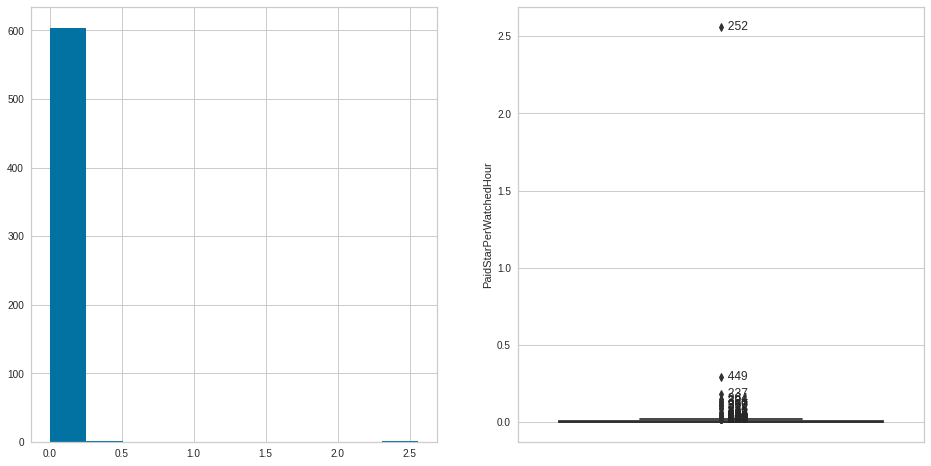

In [ ]:
# Create a histogram and boxplot for PaidStarPerWatchedHour to check its distribution
temp = df["PaidStarPerWatchedHour"]
q1 = temp.quantile(0.25)
q3 = temp.quantile(0.75)
outlier_top_lim = q3 + 1.5 * (q3 - q1)
outlier_bottom_lim = q1 - 1.5 * (q3 - q1)

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].hist(temp, bins = 10)
sns.boxplot(y = temp, ax = ax[1])

for ind, val in enumerate(temp):
  if val > outlier_top_lim or val < outlier_bottom_lim:
        ax[1].text(0, val, f'  {ind}', ha='left', va='center')

plt.show()

From here we could see that there are anomalies/outliers in the data.

In [ ]:
# Count the inital number of outlier
out = 0
for val in temp:
  if val > outlier_top_lim or val < outlier_bottom_lim:
    out += 1
out

66

In [ ]:
# Check the outlier based on the max PaidStarPerWatchedHour
df.sort_values("PaidStarPerWatchedHour", ascending = False).head(10)

,Country,Gender,Game,MBTI_grouped,Total Follower,Broadcast Hours,Character_Facet_Cont_Rigidity,Character_Facet_Cont_AchievementStriving,Personal_Values_Facet_Cont_Hedonism,Character_Facet_Cont_Dutifulness,Character_Cont_Conscientiousness,Character_Facet_Cont_Sympathy,Personal_Values_Facet_Cont_UniversalismTolerance,Temperament_Choleric,Self_Esteem_Cont_SEDiscrepancyResponsibility,Character_Facet_Cont_ArtisticInterests,Temperament_Sanguine,Character_Facet_Cont_Friendliness,Temperament_Diligent,Self_Esteem_Cont_SELevel,Character_Cont_Extraversion,Role_Director,Character_Facet_Cont_SelfConsciousness,Temperament_Energetic,Character_Facet_Cont_Adventurousness,Role_Craftsman,Self_Esteem_Cont_SELevelResponsibility,Self_Esteem_Cont_SEAspirationResponsibility,Role_Toastmaster,Personal_Values_Facet_Cont_PowerDominance,Role_Marshal,Self_Esteem_Cont_SELevelAchievements,Self_Esteem_Cont_SEDiscrepancySociability,Personal_Values_Cont_SelfEnhancement,Self_Esteem_Cont_SEAspiration,Role_Supplier,Character_Facet_Cont_Activity,Temperament_Stable,Personal_Values_Facet_Cont_PowerResources,Self_Esteem_Cont_SEDiscrepancyAchievements,...,Personal_Values_Facet_Cont_SecurityPersonal,Personal_Values_Facet_Cont_UniversalismConcern,Role_Advisor,Self_Esteem_Cont_SELevelOriginality,Role_Analyst,Personal_Values_Cont_SelfTranscendence,Personal_Values_Facet_Cont_Achievement,Character_Facet_Cont_Trust,Temperament_Unstable,Character_Cont_Agreeableness,Role_Inventor,Personal_Values_Facet_Cont_BenevolenceCaring,Personal_Values_Facet_Cont_BenevolenceDependability,Character_Facet_Cont_Vulnerability,Character_Facet_Cont_ExcitementSeeking,Role_Designer,Role_Deputy,Personal_Values_Cont_OpennessToChange,Character_Facet_Cont_Morality,Character_Facet_Cont_Depression,Role_Strategist,Role_Inspector,Self_Esteem_Cont_SEAspirationAppearance,Character_Facet_Cont_SelfDiscipline,Self_Esteem_Cont_SEDiscrepancyIntelligence,Role_Companion,Character_Facet_Cont_Cooperation,Role_Commander,Role_Activist,Personal_Values_Facet_Cont_UniversalismNature,Role_Charismatic,Personal_Values_Facet_Cont_Tradition,Self_Esteem_Cont_SELevelAppearance,Character_Facet_Cont_Assertiveness,Character_Facet_Cont_Cautiousness,Role_Curator,Personal_Values_Cont_Conservation,Self_Esteem_Cont_SELevelIntelligence,Temperament_Centric,PaidStarPerWatchedHour
252,PH,Female,League of Legends,IST,77691,99,0.584904,0.147553,0.853163,0.351221,0.227138,0.306054,0.626905,0.00,0.564933,0.499682,0.00,0.673589,0.750,0.504936,0.428802,0.379514,0.605110,0.500,0.738572,0.683350,0.499198,0.580993,0.586604,0.363641,0.170378,0.216864,0.524559,0.247013,0.826980,0.207942,0.474588,0.125,0.214188,0.430580,...,0.440805,0.583615,0.166623,0.587501,0.336963,0.292814,0.286875,0.412365,0.125,0.243967,0.471914,0.508606,0.341187,0.636849,0.607294,0.472013,0.358040,0.296545,0.738572,0.665751,0.333122,0.420180,0.897316,0.399327,0.367699,0.394035,0.144014,0.171283,0.240869,0.505296,0.364484,0.345694,0.420043,0.329571,0.332496,0.087271,0.289647,0.749248,0.625,2.561621
449,VN,Female,League of Legends,IST,36266,102,0.561336,0.378814,0.547942,0.567108,0.496743,0.389375,0.552733,0.00,0.349346,0.466689,0.25,0.544486,0.375,0.704625,0.397027,0.660348,0.536923,0.125,0.618865,0.646709,0.612115,0.625672,0.601269,0.357272,0.487343,0.244142,0.456885,0.242600,0.875690,0.518295,0.550334,0.375,0.209313,0.553511,...,0.603522,0.622552,0.593427,0.678415,0.722407,0.264304,0.298507,0.505871,0.125,0.413804,0.686741,0.566174,0.349979,0.628771,0.635441,0.620921,0.519184,0.279882,0.618865,0.663353,0.770253,0.808813,0.887988,0.397442,0.300209,0.543926,0.328976,0.444178,0.439392,0.594737,0.397342,0.341652,0.458656,0.412747,0.387027,0.418017,0.291648,0.742862,0.250,0.294624
237,PH,Female,Apex Legends,IST,24803,91,0.404306,0.282998,0.632045,0.442021,0.414235,0.424413,0.659357,0.00,0.528051,0.427518,0.25,0.339296,0.625,0.449953,0.163924,0.384719,0.499814,0.125,0.403213,0.606661,0.563553,0.618476,0.395903,0.361090,0.281578,0.368527,0.506669,0.241579,0.866095,0.184403,0.433344,0.

In [ ]:
# Removing outliers until there are no outliers in the data

# Looping until there are no outliers
while out > 0:
  out_ind = []
  for ind, val in enumerate(temp):
    if val > outlier_top_lim or val < outlier_bottom_lim:
      out_ind.append(ind)
  
  if len(out_ind) > 0:
    df = df.drop(out_ind)
    df = df.reset_index(drop = True)
    temp = df["PaidStarPerWatchedHour"]

  # Update the number of outliers
  q1 = temp.quantile(0.25)
  q3 = temp.quantile(0.75)
  outlier_top_lim = q3 + 1.5 * (q3 - q1)
  outlier_bottom_lim = q1 - 1.5 * (q3 - q1)
  
  out = 0
  for val in temp:
    if val > outlier_top_lim or val < outlier_bottom_lim:
      out += 1

df.shape

(505, 125)

We could see that there are 69 outliers and we could drop them from the data. This approach is needed to make our model to have better performance.

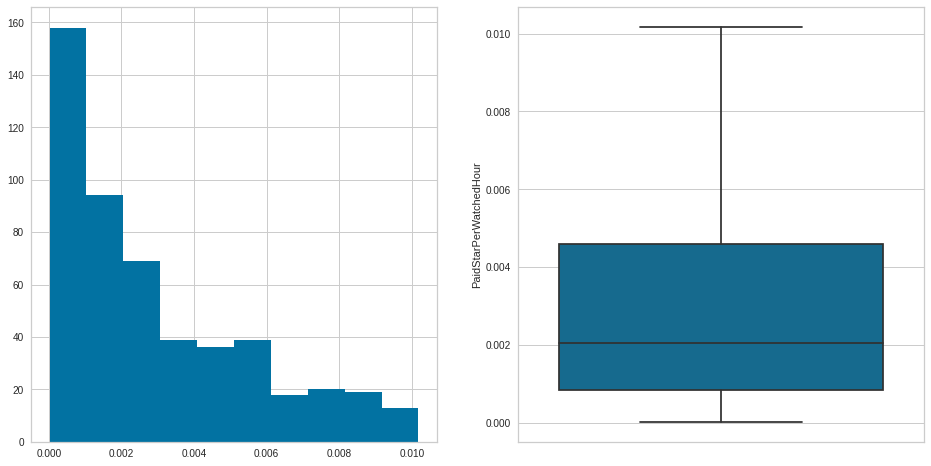

In [ ]:
# Create a histogram and boxplot for PaidStarPerWatchedHour to check its distribution
temp = df["PaidStarPerWatchedHour"]
q1 = temp.quantile(0.25)
q3 = temp.quantile(0.75)
outlier_top_lim = q3 + 1.5 * (q3 - q1)
outlier_bottom_lim = q1 - 1.5 * (q3 - q1)

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].hist(temp, bins = 10)
sns.boxplot(y = temp, ax = ax[1])

for ind, val in enumerate(temp):
  if val > outlier_top_lim or val < outlier_bottom_lim:
        ax[1].text(0, val, f'  {ind}', ha='left', va='center')

plt.show()

Now our data don't have any outliers.

In [ ]:
# Descriptive statistics (2)
round(describe(df["PaidStarPerWatchedHour"]), 3)

,PaidStarPerWatchedHour
nobs,505.000
missing,0.000
mean,0.003
std_err,0.000
upper_ci,0.003
lower_ci,0.003
std,0.003
iqr,0.004
iqr_normal,0.003
mad,0.002


## Categorical Features

In [ ]:
# Check the number of observations grouped by Country
df.groupby("Country")["Country"].count().sort_values(ascending = False)

Country
ID    203
VN    193
PH    109
Name: Country, dtype: int64

In [ ]:
# Create a function to visualize data in a pie chart and a boxplot
def viz_pie_box(data, feature, target = "PaidStarPerWatchedHour", figsize = (16, 8), legend = True, rotation = 0):
  temp = data.groupby(feature)[feature].count().sort_values(ascending = False)

  fig, ax = plt.subplots(1, 2, figsize = figsize)

  ax[0].pie(temp.values,
            autopct = lambda x: str(round(x, 2)) + "%",
            labels = temp.index)
  if legend:
    ax[0].legend()
  
  data.boxplot(target, by = feature, ax = ax[1], rot = rotation)

  plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


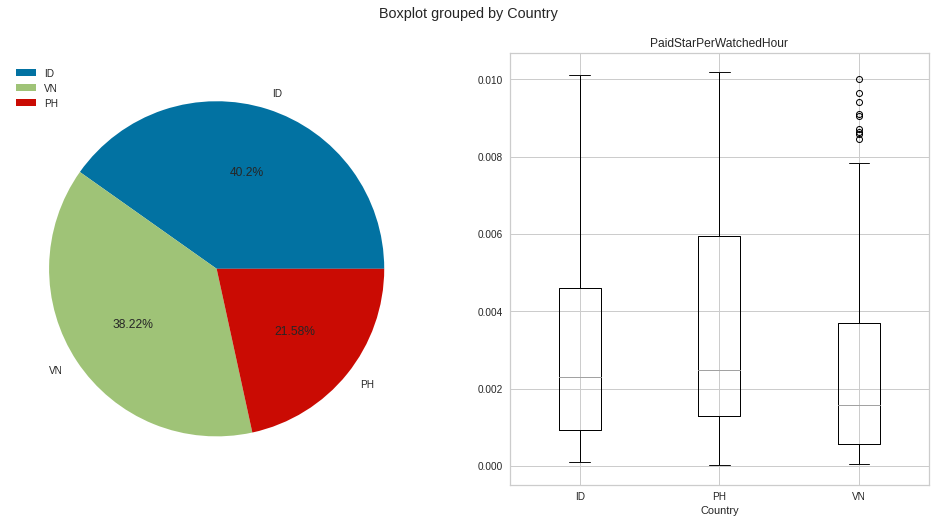

In [ ]:
# Create a pie chart and a boxplot to visualize for Country
viz_pie_box(df, "Country")

In [ ]:
# Create a function for Kruskal Wallis test
def kruskal_test(data, feature, target = "PaidStarPerWatchedHour"):
  temp = data.groupby(feature)[feature].count().sort_values(ascending = False)
  temp = temp.index.to_list()

  temp_dict = {}
  for i in temp:
    temp_dict[i] = list(df[df[feature] == i][target])
  
  stat, pval = stats.kruskal(*list(temp_dict.values()))

  print("Kruskal Wallis Test")
  if pval < 0.05:
    print("There are different in median values")
  else:
    print("There are no different in median values")
  print("statistics = %5.2f" % stat)
  print("p-value = %5.2f" % pval)

In [ ]:
# Kruskal wallis test for Country
kruskal_test(df, "Country")

Kruskal Wallis Test
There are different in median values
statistics = 15.17
p-value =  0.00


In [ ]:
# Check the number of observations grouped by Gender
df.groupby("Gender")["Gender"].count().sort_values(ascending = False)

Gender
Male      397
Female    108
Name: Gender, dtype: int64

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


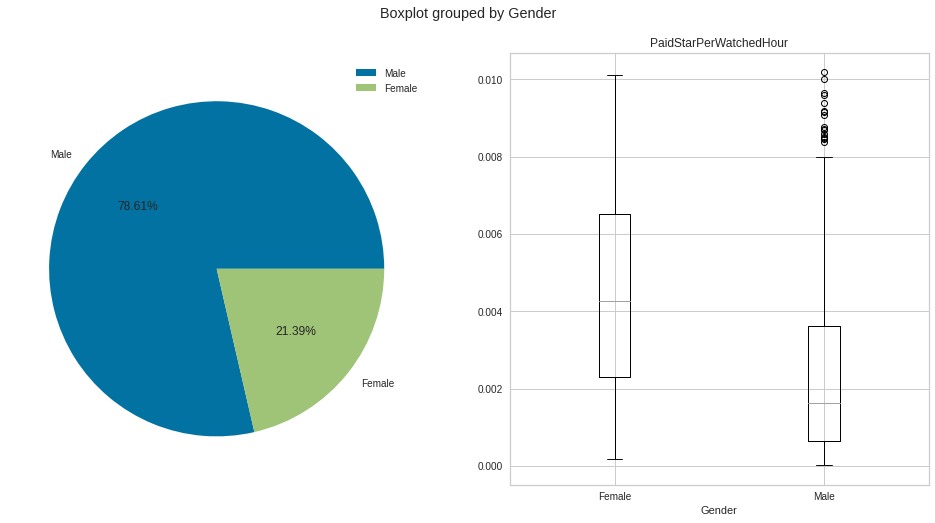

In [ ]:
# Create a pie chart and a boxplot to visualize for Gender
viz_pie_box(df, "Gender")

In [ ]:
# Kruskal wallis test for Gender
kruskal_test(df, "Gender")

Kruskal Wallis Test
There are different in median values
statistics = 54.11
p-value =  0.00


In [ ]:
# Check the number of observations grouped by Country
df.groupby("Game")["Game"].count().sort_values(ascending = False)

Game
MLBB                                        118
PUBG                                         95
Free Fire - Battlegrounds                    47
Arena of Valor                               39
Age of Empires                               23
League of Legends                            23
Grand Theft Auto V                           16
Crossfire                                    12
Worms Zone                                   11
Dota 2                                        9
Garena Liên Quân Mobile                       8
Euro Truck Simulator 2                        8
Counter-Strike: Global Offensive              6
eFootball PES 2020                            6
Coin Master                                   6
Wormate.io                                    6
Dead by Daylight                              4
Auto Chess                                    4
Valorant                                      4
RULES OF SURVIVAL                             4
NBA 2K20                           

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


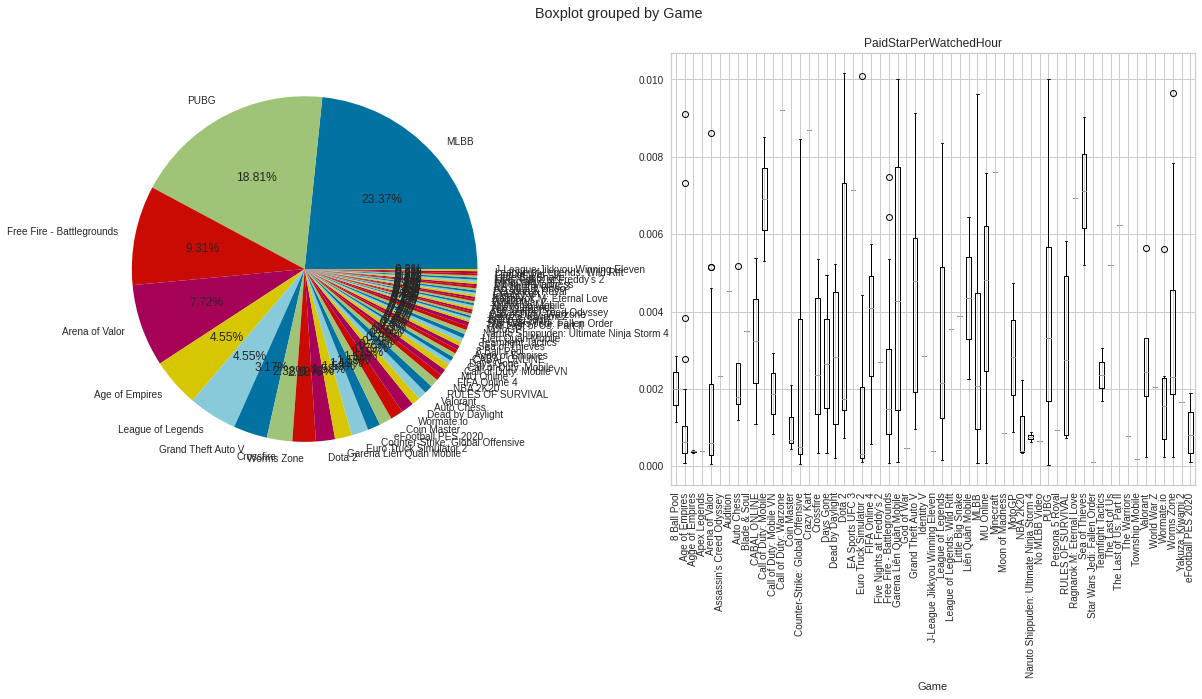

In [ ]:
# Create a pie chart and a boxplot to visualize for Game
viz_pie_box(df, "Game", figsize = (20, 8), legend = False, rotation = 90)

In [ ]:
# Kruskal wallis test for Game
kruskal_test(df, "Game")

Kruskal Wallis Test
There are different in median values
statistics = 117.40
p-value =  0.00


In [ ]:
# Check the number of observations grouped by MBTI_grouped
df.groupby("MBTI_grouped")["MBTI_grouped"].count().sort_values(ascending = False)

MBTI_grouped
ENT    247
IST    119
INT    111
ENF      8
INF      7
EST      6
ISF      4
ESF      3
Name: MBTI_grouped, dtype: int64

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


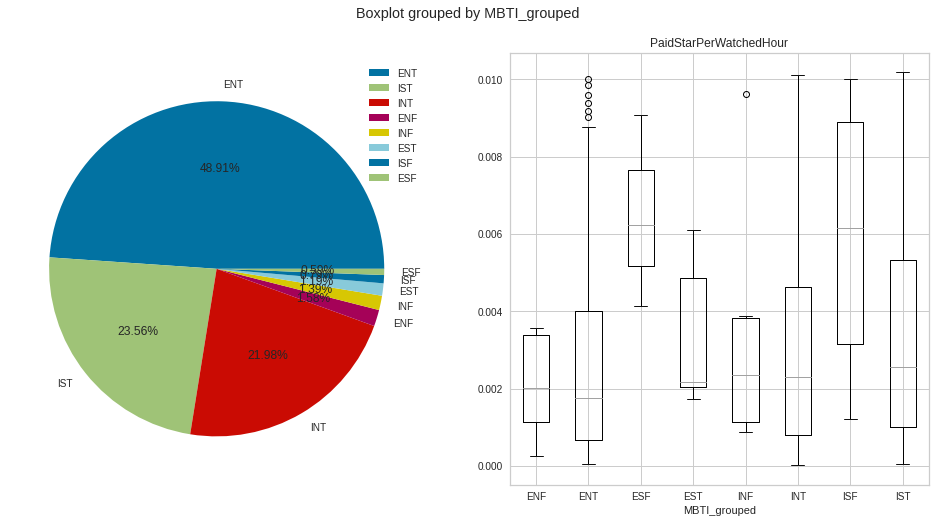

In [ ]:
# Create a pie chart and a boxplot to visualize for MBTI_grouped
viz_pie_box(df, "MBTI_grouped")

In [ ]:
# Kruskal wallis test for MBTI_grouped
kruskal_test(df, "MBTI_grouped")

Kruskal Wallis Test
There are different in median values
statistics = 14.66
p-value =  0.04


All the categorical variables shown indication of significant effect to the PaidStarPerWatchedHour. But, we need to do some pre-processing for the Game and MBTI_grouped variables because they have many category (>3).

### Pre-processing Game and MBTI_grouped

In [ ]:
# Clean the Game and MBTI_grouped columns by creating a list to store its clean values
game = df.groupby("Game")["Game"].count().sort_values(ascending = False).index.to_list()[:3]
mbti = df.groupby("MBTI_grouped")["MBTI_grouped"].count().sort_values(ascending = False).index.to_list()[:3]

game_list = []
for i in df["Game"]:
  if i in game:
    game_list.append(i)
  else:
    game_list.append("Other")

mbti_list = []
for i in df["MBTI_grouped"]:
  if i in mbti:
    mbti_list.append(i)
  else:
    mbti_list.append("Other")

In [ ]:
# Update the columns
df["Game"] = game_list
df["MBTI_grouped"] = mbti_list
df

,Country,Gender,Game,MBTI_grouped,Total Follower,Broadcast Hours,Character_Facet_Cont_Rigidity,Character_Facet_Cont_AchievementStriving,Personal_Values_Facet_Cont_Hedonism,Character_Facet_Cont_Dutifulness,Character_Cont_Conscientiousness,Character_Facet_Cont_Sympathy,Personal_Values_Facet_Cont_UniversalismTolerance,Temperament_Choleric,Self_Esteem_Cont_SEDiscrepancyResponsibility,Character_Facet_Cont_ArtisticInterests,Temperament_Sanguine,Character_Facet_Cont_Friendliness,Temperament_Diligent,Self_Esteem_Cont_SELevel,Character_Cont_Extraversion,Role_Director,Character_Facet_Cont_SelfConsciousness,Temperament_Energetic,Character_Facet_Cont_Adventurousness,Role_Craftsman,Self_Esteem_Cont_SELevelResponsibility,Self_Esteem_Cont_SEAspirationResponsibility,Role_Toastmaster,Personal_Values_Facet_Cont_PowerDominance,Role_Marshal,Self_Esteem_Cont_SELevelAchievements,Self_Esteem_Cont_SEDiscrepancySociability,Personal_Values_Cont_SelfEnhancement,Self_Esteem_Cont_SEAspiration,Role_Supplier,Character_Facet_Cont_Activity,Temperament_Stable,Personal_Values_Facet_Cont_PowerResources,Self_Esteem_Cont_SEDiscrepancyAchievements,...,Personal_Values_Facet_Cont_SecurityPersonal,Personal_Values_Facet_Cont_UniversalismConcern,Role_Advisor,Self_Esteem_Cont_SELevelOriginality,Role_Analyst,Personal_Values_Cont_SelfTranscendence,Personal_Values_Facet_Cont_Achievement,Character_Facet_Cont_Trust,Temperament_Unstable,Character_Cont_Agreeableness,Role_Inventor,Personal_Values_Facet_Cont_BenevolenceCaring,Personal_Values_Facet_Cont_BenevolenceDependability,Character_Facet_Cont_Vulnerability,Character_Facet_Cont_ExcitementSeeking,Role_Designer,Role_Deputy,Personal_Values_Cont_OpennessToChange,Character_Facet_Cont_Morality,Character_Facet_Cont_Depression,Role_Strategist,Role_Inspector,Self_Esteem_Cont_SEAspirationAppearance,Character_Facet_Cont_SelfDiscipline,Self_Esteem_Cont_SEDiscrepancyIntelligence,Role_Companion,Character_Facet_Cont_Cooperation,Role_Commander,Role_Activist,Personal_Values_Facet_Cont_UniversalismNature,Role_Charismatic,Personal_Values_Facet_Cont_Tradition,Self_Esteem_Cont_SELevelAppearance,Character_Facet_Cont_Assertiveness,Character_Facet_Cont_Cautiousness,Role_Curator,Personal_Values_Cont_Conservation,Self_Esteem_Cont_SELevelIntelligence,Temperament_Centric,PaidStarPerWatchedHour
0,ID,Male,MLBB,INT,96751,104,0.663442,0.718679,0.288008,0.471456,0.522711,0.337836,0.554134,0.00,0.496688,0.504059,0.25,0.494384,0.125,0.462912,0.474577,0.679339,0.471482,0.125,0.544957,0.453882,0.679427,0.721495,0.530887,0.356304,0.620860,0.605858,0.473335,0.303076,0.881936,0.509514,0.691145,0.750,0.317289,0.544263,...,0.353928,0.477637,0.577660,0.728769,0.627180,0.275763,0.322608,0.450080,0.500,0.467756,0.705475,0.543155,0.244511,0.686694,0.554406,0.533952,0.516859,0.303909,0.553544,0.771031,0.783868,0.670467,0.648751,0.518061,0.473907,0.541372,0.352032,0.449807,0.514417,0.523116,0.408444,0.318747,0.684412,0.494384,0.751974,0.524306,0.299052,0.803920,0.625,0.004113
1,ID,Male,Other,INT,4781,174,0.543255,0.427887,0.430609,0.493514,0.348513,0.408481,0.610872,0.00,0.557879,0.577758,0.50,0.468738,0.250,0.386516,0.445183,0.381432,0.352964,0.000,0.604113,0.325222,0.743407,0.534425,0.349459,0.341675,0.486200,0.490160,0.579283,0.298714,0.860851,0.098237,0.554197,0.625,0.317427,0.583342,...,0.425649,0.456436,0.239550,0.771001,0.403616,0.264248,0.333644,0.504510,0.125,0.225692,0.718745,0.460678,0.276966,0.627786,0.511837,0.488030,0.263292,0.309062,0.352700,0.462166,0.549318,0.397981,0.690168,0.442303,0.482889,0.230455,0.401419,0.277163,0.286003,0.444493,0.407624,0.382594,0.635493,0.468738,0.571198,0.100202,0.304527,0.751291,0.125,0.002855
2,ID,Female,Free Fire - Battlegrounds,IST,68246,83,0.527279,0.399873,0.753009,0.472405,0.376854,0.518602,0.579433,0.50,0.395199,0.594752,0.00,0.413872,0.500,0.568077,0.322573,0.305979,0.750039,0.000,0.657773,0.784232,0.555626,0.568014,0.555618,0.362791,0.177483,0.189999,0.510046,0.231113,0.805830,0.360728,0.546109,0.000,0.216132,0.573285,

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


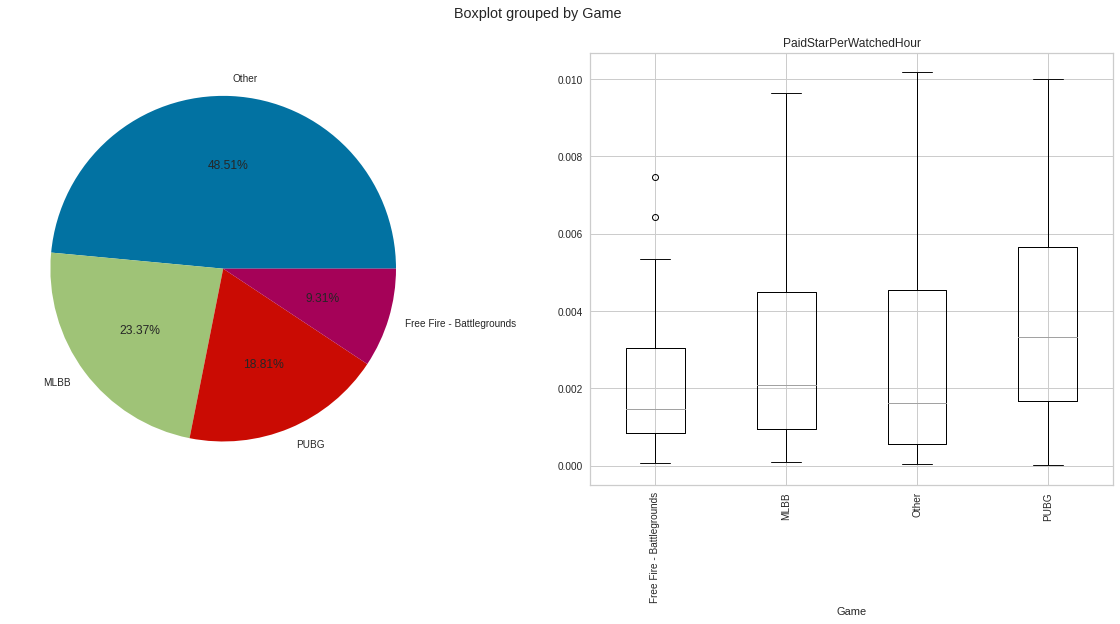

In [ ]:
# Create a pie chart and a boxplot to visualize for Game
viz_pie_box(df, "Game", figsize = (20, 8), legend = False, rotation = 90)

In [ ]:
# Kruskal wallis test for Game
kruskal_test(df, "Game")

Kruskal Wallis Test
There are different in median values
statistics = 25.08
p-value =  0.00


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


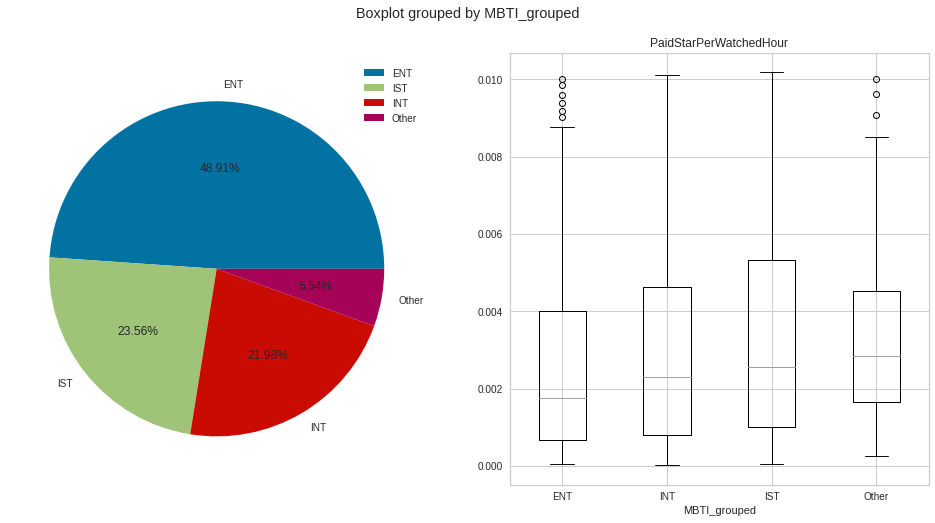

In [ ]:
# Create a pie chart and a boxplot to visualize for MBTI_grouped
viz_pie_box(df, "MBTI_grouped")

In [ ]:
# Kruskal wallis test for MBTI_grouped
kruskal_test(df, "MBTI_grouped")

Kruskal Wallis Test
There are different in median values
statistics =  8.81
p-value =  0.03


## Numerical Features

In [ ]:
# Descriptive statistics for numerical features
desstat = describe(df).loc[["mean", "median", "max", "min", "std", "jarque_bera", "jarque_bera_pval"], :].iloc[:, :-1]
desstat

,Total Follower,Broadcast Hours,Character_Facet_Cont_Rigidity,Character_Facet_Cont_AchievementStriving,Personal_Values_Facet_Cont_Hedonism,Character_Facet_Cont_Dutifulness,Character_Cont_Conscientiousness,Character_Facet_Cont_Sympathy,Personal_Values_Facet_Cont_UniversalismTolerance,Temperament_Choleric,Self_Esteem_Cont_SEDiscrepancyResponsibility,Character_Facet_Cont_ArtisticInterests,Temperament_Sanguine,Character_Facet_Cont_Friendliness,Temperament_Diligent,Self_Esteem_Cont_SELevel,Character_Cont_Extraversion,Role_Director,Character_Facet_Cont_SelfConsciousness,Temperament_Energetic,Character_Facet_Cont_Adventurousness,Role_Craftsman,Self_Esteem_Cont_SELevelResponsibility,Self_Esteem_Cont_SEAspirationResponsibility,Role_Toastmaster,Personal_Values_Facet_Cont_PowerDominance,Role_Marshal,Self_Esteem_Cont_SELevelAchievements,Self_Esteem_Cont_SEDiscrepancySociability,Personal_Values_Cont_SelfEnhancement,Self_Esteem_Cont_SEAspiration,Role_Supplier,Character_Facet_Cont_Activity,Temperament_Stable,Personal_Values_Facet_Cont_PowerResources,Self_Esteem_Cont_SEDiscrepancyAchievements,Temperament_Melancholic,Character_Cont_Openness,Character_Facet_Cont_Anxiety,Role_Administrator,...,Role_Promoter,Personal_Values_Facet_Cont_SecurityPersonal,Personal_Values_Facet_Cont_UniversalismConcern,Role_Advisor,Self_Esteem_Cont_SELevelOriginality,Role_Analyst,Personal_Values_Cont_SelfTranscendence,Personal_Values_Facet_Cont_Achievement,Character_Facet_Cont_Trust,Temperament_Unstable,Character_Cont_Agreeableness,Role_Inventor,Personal_Values_Facet_Cont_BenevolenceCaring,Personal_Values_Facet_Cont_BenevolenceDependability,Character_Facet_Cont_Vulnerability,Character_Facet_Cont_ExcitementSeeking,Role_Designer,Role_Deputy,Personal_Values_Cont_OpennessToChange,Character_Facet_Cont_Morality,Character_Facet_Cont_Depression,Role_Strategist,Role_Inspector,Self_Esteem_Cont_SEAspirationAppearance,Character_Facet_Cont_SelfDiscipline,Self_Esteem_Cont_SEDiscrepancyIntelligence,Role_Companion,Character_Facet_Cont_Cooperation,Role_Commander,Role_Activist,Personal_Values_Facet_Cont_UniversalismNature,Role_Charismatic,Personal_Values_Facet_Cont_Tradition,Self_Esteem_Cont_SELevelAppearance,Character_Facet_Cont_Assertiveness,Character_Facet_Cont_Cautiousness,Role_Curator,Personal_Values_Cont_Conservation,Self_Esteem_Cont_SELevelIntelligence,Temperament_Centric
mean,2.265929e+05,129.174257,0.608499,0.523932,0.498795,0.487944,0.479255,0.401457,0.556005,2.054455e-01,5.092856e-01,0.545533,3.539604e-01,0.523805,3.034653e-01,0.543431,0.494942,0.522725,0.476878,3.366337e-01,0.612121,0.460083,6.662565e-01,0.719527,5.061360e-01,0.343140,0.563822,0.440069,5.077237e-01,2.800475e-01,8.646404e-01,0.349951,0.594545,3.472772e-01,2.834422e-01,5.384007e-01,1.722772e-01,0.590615,0.587696,0.507419,...,5.527605e-01,0.454333,0.487757,0.432535,6.984476e-01,0.582041,0.256803,3.114272e-01,0.470781,1.987624e-01,0.312935,6.188432e-01,4.944597e-01,0.295180,0.682668,0.581554,0.560902,0.305017,2.989030e-01,3.751880e-01,0.635830,0.622143,0.519829,0.730198,0.485869,4.347932e-01,0.408621,0.391506,0.492761,0.419391,4.806856e-01,0.490159,3.541325e-01,6.376033e-01,0.504378,0.525887,0.262903,2.995911e-01,0.772546,3.299505e-01
median,7.551500e+04,114.000000,0.602090,0.541650,0.522128,0.496916,0.489552,0.390277,0.552733,2.500000e-01,5.441073e-01,0.548084,2.500000e-01,0.539407,3.750000e-01,0.538795,0.498180,0.530861,0.487255,2.500000e-01,0.618865,0.485353,6.748399e-01,0.737598,5.362956e-01,0.341990,0.569753,0.459953,5.069962e-01,2.923595e-01,8.756904e-01,0.346856,0.580037,3.750000e-01,3.141863e-01,5.423773e-01,0.000000e+00,0.594572,0.591317,0.506026,...,5.772090e-01,0.444923,0.484921,0.439083,7.091510e-01,0.590148,0.261230,3.164831e-01,0.490683,1.250000e-01,0.307030,6.551335e-01,5.054608e-01,0.297632,0.686421,0.588927,0.606678,0.300945,3.015774e-01,3.257828e-01,0.657202,0.627064,0.499224,0.711744,0.478468,4.745908e-01,0.421520,0.388701,0.481029,0.439392,4.649185e-01,0.488183,3.416519e-01,6.765225e-01,0.50

From the table of descriptive statistics above we could conclude that the numerical features don't have the same scale. Therefore, we need to scale the data before its get into the modeling process.

In [ ]:
# The total number of numerical features
len(desstat.columns)

120

There are 120 numerical features in the dataset.

In [ ]:
# Extract the AI facial features
temp = ["Self_Esteem_", "Character_Facet_", "Personal_Values_Facet_", "Temperament_"]
AI_features = []

for i in df.columns.to_list():
  for j in temp:
    if i.startswith(j):
      AI_features.append(i)

len(AI_features)

77

In [ ]:
# Categorical features
cat_features = ["Gender", "Country", "Game", "MBTI_grouped"]

# Other features
other_features = [i for i in df.columns if i not in AI_features and i not in cat_features and i not in ["PaidStarPerWatchedHour"]]

In [ ]:
len(other_features)

43

In [ ]:
# Check the element of other_features list to see which features inside the list
other_features

['Total Follower',
 'Broadcast Hours',
 'Character_Cont_Conscientiousness',
 'Character_Cont_Extraversion',
 'Role_Director',
 'Role_Craftsman',
 'Role_Toastmaster',
 'Role_Marshal',
 'Personal_Values_Cont_SelfEnhancement',
 'Role_Supplier',
 'Character_Cont_Openness',
 'Role_Administrator',
 'Role_Innovator',
 'Role_Partygoer',
 'Role_Guru',
 'Role_Guardian',
 'Role_Keeper',
 'Role_Manager',
 'Character_Cont_Neuroticism',
 'Role_WiseMan',
 'Role_Assistant',
 'Role_Healer',
 'Role_Operator',
 'Role_Coach',
 'Role_RightsDefender',
 'Role_Philanthropist',
 'Role_Promoter',
 'Role_Advisor',
 'Role_Analyst',
 'Personal_Values_Cont_SelfTranscendence',
 'Character_Cont_Agreeableness',
 'Role_Inventor',
 'Role_Designer',
 'Role_Deputy',
 'Personal_Values_Cont_OpennessToChange',
 'Role_Strategist',
 'Role_Inspector',
 'Role_Companion',
 'Role_Commander',
 'Role_Activist',
 'Role_Charismatic',
 'Role_Curator',
 'Personal_Values_Cont_Conservation']

In [ ]:
# Check if there are any features that has correlation coefficient greater than 0.5
temp = abs(df.corr(method = "spearman")["PaidStarPerWatchedHour"]) > 0.5
temp.values[:-1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

Unfortunately, there are no features that has the absolute value of coefficient correlation greater than 0.5.

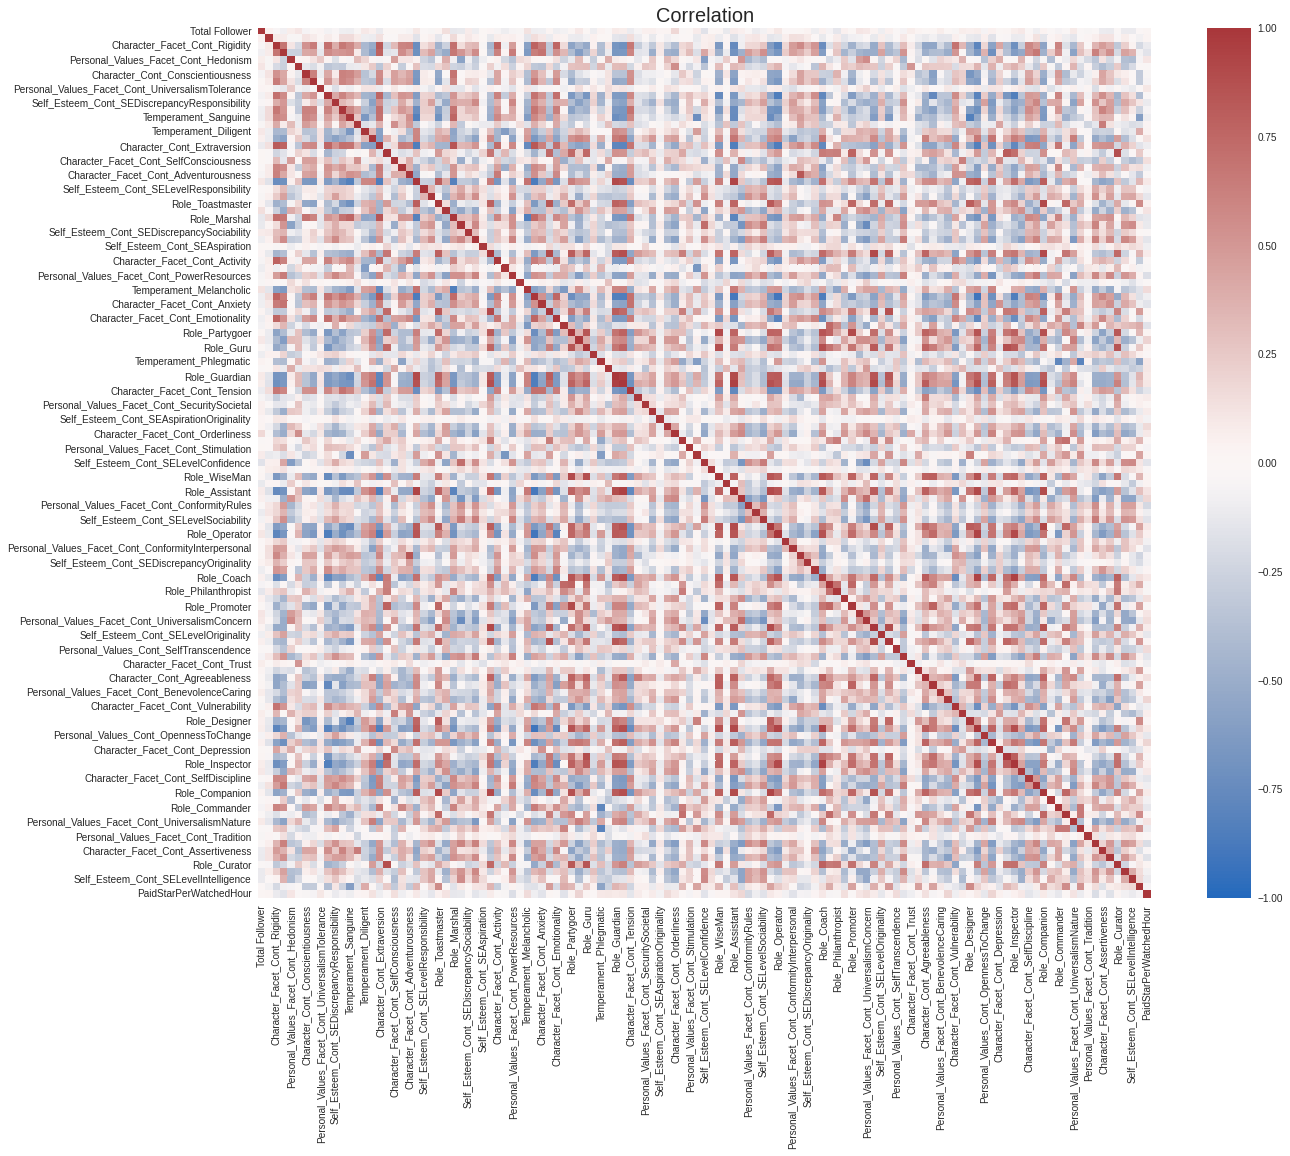

In [ ]:
# Creating a heatmap to get the information about correlation value between numerical variables

plt.figure(figsize = (20,16))
sns.heatmap(df.corr(method = "spearman"), vmin = -1, vmax = 1, center = 0, cmap = "vlag")
plt.title("Correlation", fontsize = 20)
plt.show()

There are too many variables included in the correlation heatmap and it caused the heatmap too difficult to understand. But, if we focuse in the PaidStarPerWatchedHour we could see that it doesn't have any indication of high correlation with other variables (features).

# Modeling

Supervised: Linear Regression, Random Forest

Unsupervised: K-Means

## Dummy Variables

In [ ]:
# List of columns with categorical features
cat_features

['Gender', 'Country', 'Game', 'MBTI_grouped']

Our main goal is to learn whether certain features of streamers will make them more or less likely to receive stars from their audience. As we already knew that each categorical features has different median values for each of its category. Therefore, all the categorical features may contribute to more or less likely a streamer could receive their stars from their audience.

Then, we need to convert the value of each categorical features into **dummy variables**.

In [ ]:
# Create a dataframe for the dummy variables of each categorical features
cat_dummy_df = pd.get_dummies(df[cat_features])
cat_dummy_df.head()

,Gender_Female,Gender_Male,Country_ID,Country_PH,Country_VN,Game_Free Fire - Battlegrounds,Game_MLBB,Game_Other,Game_PUBG,MBTI_grouped_ENT,MBTI_grouped_INT,MBTI_grouped_IST,MBTI_grouped_Other
0,0,1,1,0,0,0,1,0,0,0,1,0,0
1,0,1,1,0,0,0,0,1,0,0,1,0,0
2,1,0,1,0,0,1,0,0,0,0,0,1,0
3,0,1,1,0,0,0,1,0,0,1,0,0,0
4,0,1,1,0,0,1,0,0,0,0,0,0,1


In [ ]:
cat_dummy_df.shape

(505, 13)

## Feature Selection

For the feature selection we'll use all the data in the dataset and create feature importance plot using random forest regression.

In [ ]:
# Create a dataset that contains the dummy variables
df_dummy = pd.concat([cat_dummy_df, df.drop(cat_features, axis = 1)], axis = 1)
df_dummy.head()

,Gender_Female,Gender_Male,Country_ID,Country_PH,Country_VN,Game_Free Fire - Battlegrounds,Game_MLBB,Game_Other,Game_PUBG,MBTI_grouped_ENT,MBTI_grouped_INT,MBTI_grouped_IST,MBTI_grouped_Other,Total Follower,Broadcast Hours,Character_Facet_Cont_Rigidity,Character_Facet_Cont_AchievementStriving,Personal_Values_Facet_Cont_Hedonism,Character_Facet_Cont_Dutifulness,Character_Cont_Conscientiousness,Character_Facet_Cont_Sympathy,Personal_Values_Facet_Cont_UniversalismTolerance,Temperament_Choleric,Self_Esteem_Cont_SEDiscrepancyResponsibility,Character_Facet_Cont_ArtisticInterests,Temperament_Sanguine,Character_Facet_Cont_Friendliness,Temperament_Diligent,Self_Esteem_Cont_SELevel,Character_Cont_Extraversion,Role_Director,Character_Facet_Cont_SelfConsciousness,Temperament_Energetic,Character_Facet_Cont_Adventurousness,Role_Craftsman,Self_Esteem_Cont_SELevelResponsibility,Self_Esteem_Cont_SEAspirationResponsibility,Role_Toastmaster,Personal_Values_Facet_Cont_PowerDominance,Role_Marshal,...,Personal_Values_Facet_Cont_SecurityPersonal,Personal_Values_Facet_Cont_UniversalismConcern,Role_Advisor,Self_Esteem_Cont_SELevelOriginality,Role_Analyst,Personal_Values_Cont_SelfTranscendence,Personal_Values_Facet_Cont_Achievement,Character_Facet_Cont_Trust,Temperament_Unstable,Character_Cont_Agreeableness,Role_Inventor,Personal_Values_Facet_Cont_BenevolenceCaring,Personal_Values_Facet_Cont_BenevolenceDependability,Character_Facet_Cont_Vulnerability,Character_Facet_Cont_ExcitementSeeking,Role_Designer,Role_Deputy,Personal_Values_Cont_OpennessToChange,Character_Facet_Cont_Morality,Character_Facet_Cont_Depression,Role_Strategist,Role_Inspector,Self_Esteem_Cont_SEAspirationAppearance,Character_Facet_Cont_SelfDiscipline,Self_Esteem_Cont_SEDiscrepancyIntelligence,Role_Companion,Character_Facet_Cont_Cooperation,Role_Commander,Role_Activist,Personal_Values_Facet_Cont_UniversalismNature,Role_Charismatic,Personal_Values_Facet_Cont_Tradition,Self_Esteem_Cont_SELevelAppearance,Character_Facet_Cont_Assertiveness,Character_Facet_Cont_Cautiousness,Role_Curator,Personal_Values_Cont_Conservation,Self_Esteem_Cont_SELevelIntelligence,Temperament_Centric,PaidStarPerWatchedHour
0,0,1,1,0,0,0,1,0,0,0,1,0,0,96751,104,0.663442,0.718679,0.288008,0.471456,0.522711,0.337836,0.554134,0.0,0.496688,0.504059,0.25,0.494384,0.125,0.462912,0.474577,0.679339,0.471482,0.125,0.544957,0.453882,0.679427,0.721495,0.530887,0.356304,0.620860,...,0.353928,0.477637,0.577660,0.728769,0.627180,0.275763,0.322608,0.450080,0.500,0.467756,0.705475,0.543155,0.244511,0.686694,0.554406,0.533952,0.516859,0.303909,0.553544,0.771031,0.783868,0.670467,0.648751,0.518061,0.473907,0.541372,0.352032,0.449807,0.514417,0.523116,0.408444,0.318747,0.684412,0.494384,0.751974,0.524306,0.299052,0.803920,0.625,0.004113
1,0,1,1,0,0,0,0,1,0,0,1,0,0,4781,174,0.543255,0.427887,0.430609,0.493514,0.348513,0.408481,0.610872,0.0,0.557879,0.577758,0.50,0.468738,0.250,0.386516,0.445183,0.381432,0.352964,0.000,0.604113,0.325222,0.743407,0.534425,0.349459,0.341675,0.486200,...,0.425649,0.456436,0.239550,0.771001,0.403616,0.264248,0.333644,0.504510,0.125,0.225692,0.718745,0.460678,0.276966,0.627786,0.511837,0.488030,0.263292,0.309062,0.352700,0.462166,0.549318,0.397981,0.690168,0.442303,0.482889,0.230455,0.401419,0.277163,0.286003,0.444493,0.407624,0.382594,0.635493,0.468738,0.571198,0.100202,0.304527,0.751291,0.125,0.002855
2,1,0,1,0,0,1,0,0,0,0,0,1,0,68246,83,0.527279,0.399873,0.753009,0.472405,0.376854,0.518602,0.579433,0.5,0.395199,0.594752,0.00,0.413872,0.500,0.568077,0.322573,0.305979,0.750039,0.000,0.657773,0.784232,0.555626,0.568014,0.555618,0.362791,0.177483,...,0.355100,0.698604,0.490699,0.546902,0.610825,0.244235,0.287052,0.458500,0.500,0.368622,0.476994,0.464157,0.391603,0.636199,0.860169,0.715200,0.302466,0.295549,0.657773,0.753035,0.437836,0.416392,0.850414,0.385781,0.354271,0.463357,0.335437,0.361047,0.401512,0.581657,0.443453,0.325263,0.398686,0.515929,0.309322,0.070988,0.305975,0.759900,0.000,0.003007
3,0,1,1,0,0,

In [ ]:
# Split the data into target and features variables
y = df_dummy.iloc[:, -1]
X = df_dummy.iloc[:, :-1]

In [ ]:
# Fit the random forest regressor
regressor = RandomForestRegressor(random_state = 0)
regressor.fit(X, y)

# Train data
ypred = regressor.predict(X)
print("Training Data")
print("RMSE :", mean_squared_error(y, ypred, squared = False)) # RMSE
print("MAE :", mean_absolute_error(y, ypred))

Training Data
RMSE : 0.000959884077905921
MAE : 0.0007593921777086235


In [ ]:
# Get importance
importance = regressor.feature_importances_
len(importance)

133

In [ ]:
# Create a dataframe for feature importance values
importance = pd.DataFrame({
    "feature": X.columns,
    "importance": importance
})

importance.head()

,feature,importance
0,Gender_Female,0.091665
1,Gender_Male,0.014329
2,Country_ID,0.001660
3,Country_PH,0.010534
4,Country_VN,0.004033


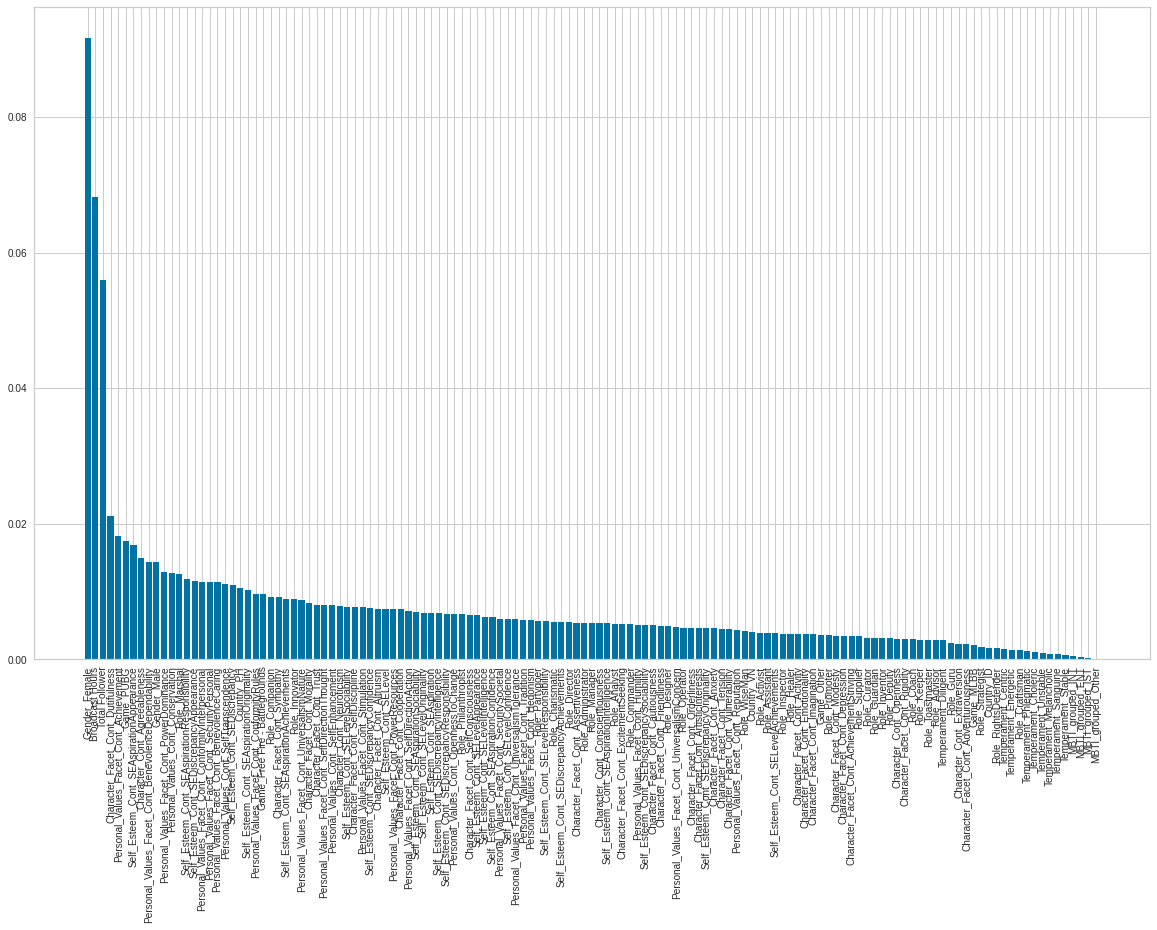

In [ ]:
# plot feature importance
plt.figure(figsize = (20, 12))
plt.bar(importance.sort_values("importance", ascending = False)["feature"], 
        importance.sort_values("importance", ascending = False)["importance"])
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# Create a column to calculate proportion of feature importance values
importance["proportion"] = round((importance['importance'] / sum(importance['importance'])) * 100, 2)
importance.head()

,feature,importance,proportion
0,Gender_Female,0.091665,9.17
1,Gender_Male,0.014329,1.43
2,Country_ID,0.001660,0.17
3,Country_PH,0.010534,1.05
4,Country_VN,0.004033,0.40


In [ ]:
# Create a column for cummulative proportion
importance = importance.sort_values("proportion", ascending = False).reset_index(drop = True)
importance["cum_prop"] = importance["proportion"].cumsum()
importance.head()

,feature,importance,proportion,cum_prop
0,Gender_Female,0.091665,9.17,9.17
1,Broadcast Hours,0.068168,6.82,15.99
2,Total Follower,0.056010,5.60,21.59
3,Character_Facet_Cont_Dutifulness,0.021198,2.12,23.71
4,Personal_Values_Facet_Cont_Achievement,0.018138,1.81,25.52


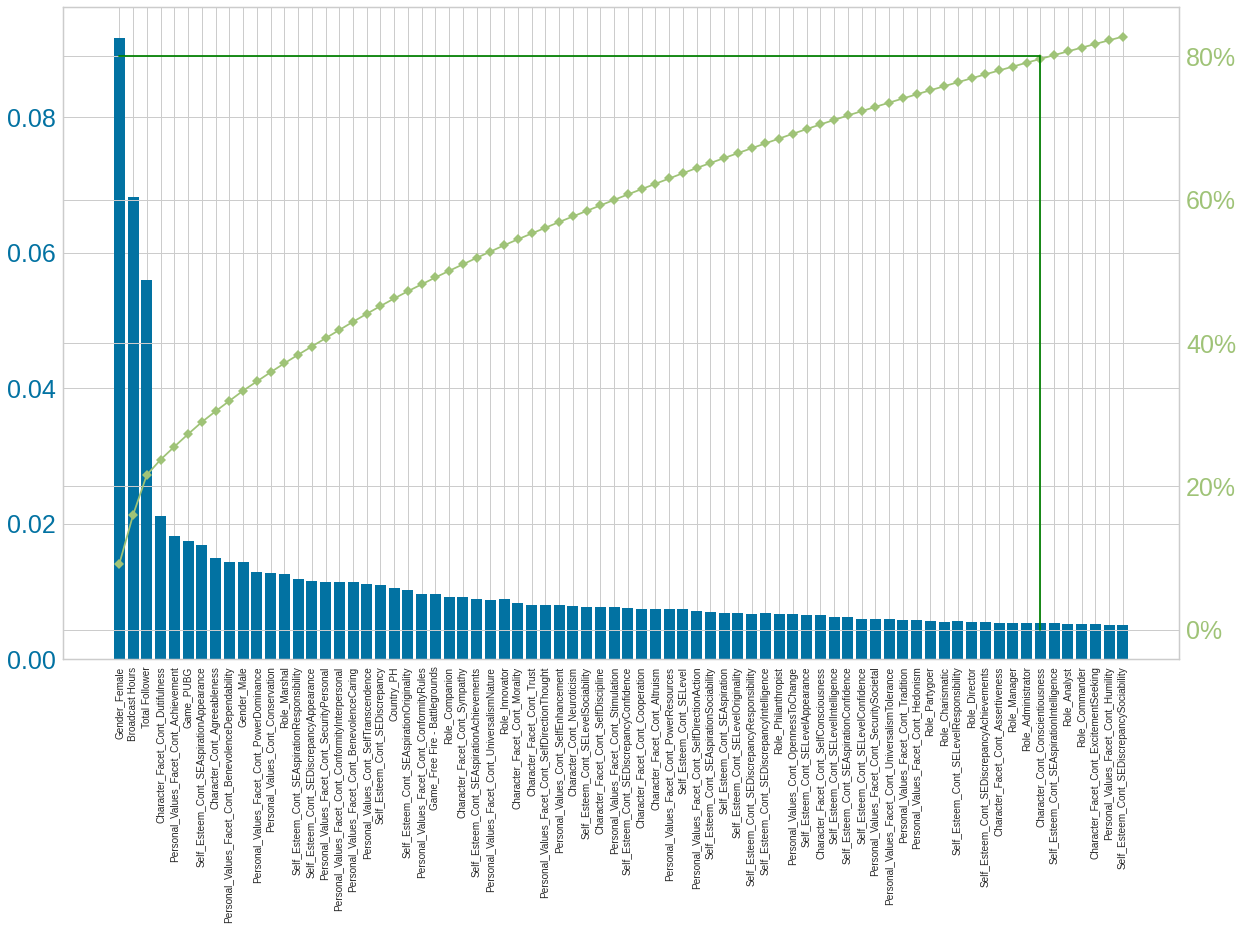

In [ ]:
# Create a pareto chart
fig, ax = plt.subplots(figsize = (20, 12))

ax.bar(importance[importance["cum_prop"] <= 83]["feature"], 
       importance[importance["cum_prop"] <= 83]["importance"], color = "C0")

ax2 = ax.twinx()
ax2.plot(importance[importance["cum_prop"] <= 83]["feature"], 
         importance[importance["cum_prop"] <= 83]["cum_prop"], 
         color = "C1", marker = "D", ms = 7)
ax2.yaxis.set_major_formatter(PercentFormatter())

plt.plot(importance[importance["cum_prop"] <= 80]["feature"], 
         [80 for i in range(len(importance[importance["cum_prop"] <= 80]))], color = "green")
plt.plot([importance[importance["cum_prop"] <= 80]["feature"].tolist()[-1]] * 2,
         [0, 80],
         color = "green")

ax.tick_params(axis = "y", colors = "C0", labelsize = 25)
ax2.tick_params(axis = "y", colors = "C1", labelsize = 25)

plt.setp(ax.get_xticklabels(), Rotation = 90)
plt.show()

In [ ]:
# Check the features that reside in 80% of total importance values
importance[importance["cum_prop"] <= 80]

,feature,importance,proportion,cum_prop
0,Gender_Female,0.091665,9.17,9.17
1,Broadcast Hours,0.068168,6.82,15.99
2,Total Follower,0.056010,5.60,21.59
3,Character_Facet_Cont_Dutifulness,0.021198,2.12,23.71
4,Personal_Values_Facet_Cont_Achievement,0.018138,1.81,25.52
...,...,...,...,...
63,Self_Esteem_Cont_SEDiscrepancyAchievements,0.005537,0.55,77.47
64,Character_Facet_Cont_Assertiveness,0.005425,0.54,78.01
65,Role_Manager,0.005359,0.54,78.55
66,Role_Administrator,0.005405,0.54,79.09


There are 68 features that has 80% of total importance.

In [ ]:
# The percentage of reduced features
round((len(X.columns) - len(importance[importance["cum_prop"] <= 80])) / len(X.columns) * 100, 2)

48.87

There are 48.87% reduced features.

In [ ]:
# Save the important features by order from the original dataset
important_feature = [i for i in X.columns.to_list() if i in importance[importance["cum_prop"] <= 80]["feature"].to_list()]
important_feature

['Gender_Female',
 'Gender_Male',
 'Country_PH',
 'Game_Free Fire - Battlegrounds',
 'Game_PUBG',
 'Total Follower',
 'Broadcast Hours',
 'Personal_Values_Facet_Cont_Hedonism',
 'Character_Facet_Cont_Dutifulness',
 'Character_Cont_Conscientiousness',
 'Character_Facet_Cont_Sympathy',
 'Personal_Values_Facet_Cont_UniversalismTolerance',
 'Self_Esteem_Cont_SEDiscrepancyResponsibility',
 'Self_Esteem_Cont_SELevel',
 'Role_Director',
 'Character_Facet_Cont_SelfConsciousness',
 'Self_Esteem_Cont_SELevelResponsibility',
 'Self_Esteem_Cont_SEAspirationResponsibility',
 'Personal_Values_Facet_Cont_PowerDominance',
 'Role_Marshal',
 'Personal_Values_Cont_SelfEnhancement',
 'Self_Esteem_Cont_SEAspiration',
 'Personal_Values_Facet_Cont_PowerResources',
 'Self_Esteem_Cont_SEDiscrepancyAchievements',
 'Role_Administrator',
 'Role_Innovator',
 'Role_Partygoer',
 'Self_Esteem_Cont_SEAspirationSociability',
 'Personal_Values_Facet_Cont_SelfDirectionThought',
 'Character_Facet_Cont_Altruism',
 'Persona

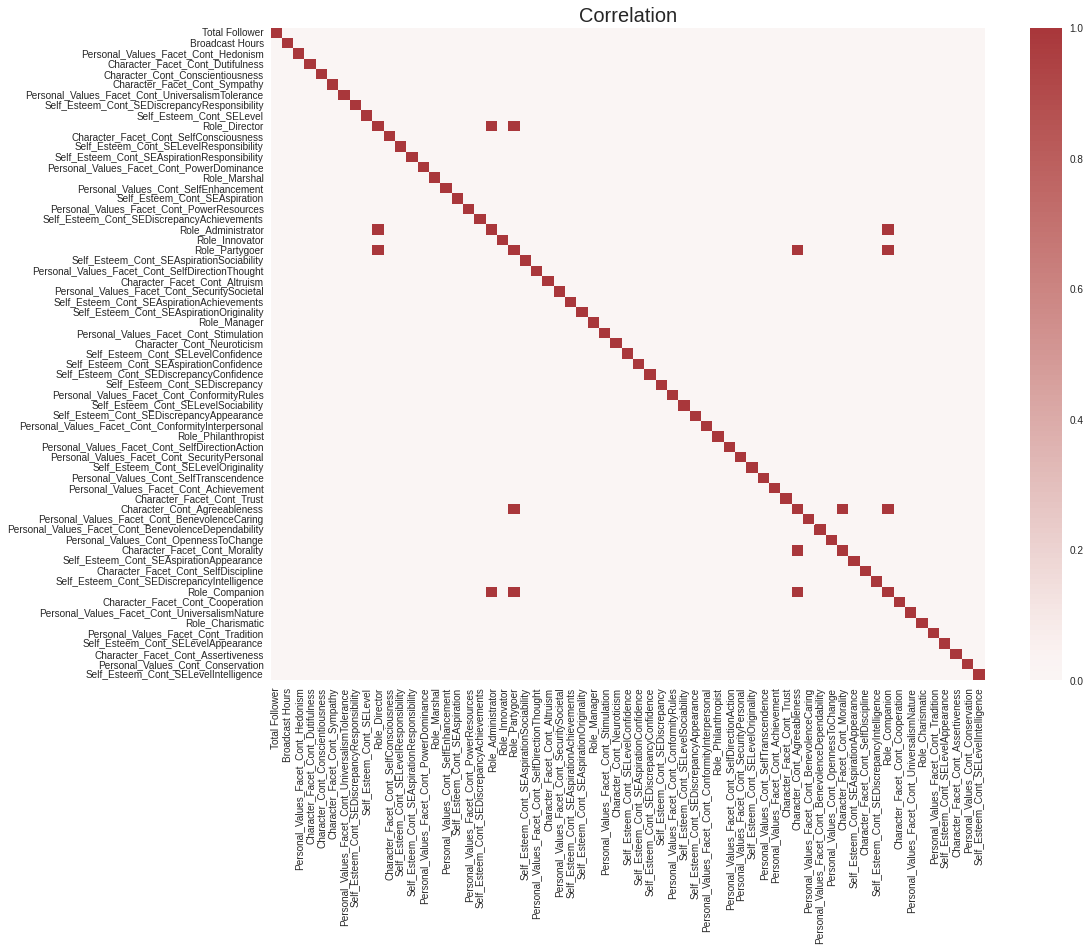

In [ ]:
# Check for multicollinearity in the numerical variable based on spearman correlation
X = X[important_feature]
temp = X.loc[:, [i for i in X.columns if i not in cat_dummy_df.columns]]

plt.figure(figsize = (16,12))

# High correlation: |Coefficient Correlation| >= 0.7
sns.heatmap(abs(temp.corr(method = "spearman")) >= 0.7, vmin = 0, vmax = 1, center = 0, cmap = "vlag")
plt.title("Correlation", fontsize = 20)
plt.show()

As you can see from the correlation heatmap above that there are multicollinearity based on the features that has high correlation (|Coefficient Correlation| >= 0.7).

In [ ]:
# Convert 1: >= 0.7 and 0: < 0.7
temp = abs(temp.corr(method = "spearman")) >= 0.7

for i in temp.columns:
  temp2 = []
  for j in temp[i]:
    if j:
      temp2.append(1)
    else:
      temp2.append(0)
  temp[i] = temp2

temp

,Total Follower,Broadcast Hours,Personal_Values_Facet_Cont_Hedonism,Character_Facet_Cont_Dutifulness,Character_Cont_Conscientiousness,Character_Facet_Cont_Sympathy,Personal_Values_Facet_Cont_UniversalismTolerance,Self_Esteem_Cont_SEDiscrepancyResponsibility,Self_Esteem_Cont_SELevel,Role_Director,Character_Facet_Cont_SelfConsciousness,Self_Esteem_Cont_SELevelResponsibility,Self_Esteem_Cont_SEAspirationResponsibility,Personal_Values_Facet_Cont_PowerDominance,Role_Marshal,Personal_Values_Cont_SelfEnhancement,Self_Esteem_Cont_SEAspiration,Personal_Values_Facet_Cont_PowerResources,Self_Esteem_Cont_SEDiscrepancyAchievements,Role_Administrator,Role_Innovator,Role_Partygoer,Self_Esteem_Cont_SEAspirationSociability,Personal_Values_Facet_Cont_SelfDirectionThought,Character_Facet_Cont_Altruism,Personal_Values_Facet_Cont_SecuritySocietal,Self_Esteem_Cont_SEAspirationAchievements,Self_Esteem_Cont_SEAspirationOriginality,Role_Manager,Personal_Values_Facet_Cont_Stimulation,Character_Cont_Neuroticism,Self_Esteem_Cont_SELevelConfidence,Self_Esteem_Cont_SEAspirationConfidence,Self_Esteem_Cont_SEDiscrepancyConfidence,Self_Esteem_Cont_SEDiscrepancy,Personal_Values_Facet_Cont_ConformityRules,Self_Esteem_Cont_SELevelSociability,Self_Esteem_Cont_SEDiscrepancyAppearance,Personal_Values_Facet_Cont_ConformityInterpersonal,Role_Philanthropist,Personal_Values_Facet_Cont_SelfDirectionAction,Personal_Values_Facet_Cont_SecurityPersonal,Self_Esteem_Cont_SELevelOriginality,Personal_Values_Cont_SelfTranscendence,Personal_Values_Facet_Cont_Achievement,Character_Facet_Cont_Trust,Character_Cont_Agreeableness,Personal_Values_Facet_Cont_BenevolenceCaring,Personal_Values_Facet_Cont_BenevolenceDependability,Personal_Values_Cont_OpennessToChange,Character_Facet_Cont_Morality,Self_Esteem_Cont_SEAspirationAppearance,Character_Facet_Cont_SelfDiscipline,Self_Esteem_Cont_SEDiscrepancyIntelligence,Role_Companion,Character_Facet_Cont_Cooperation,Personal_Values_Facet_Cont_UniversalismNature,Role_Charismatic,Personal_Values_Facet_Cont_Tradition,Self_Esteem_Cont_SELevelAppearance,Character_Facet_Cont_Assertiveness,Personal_Values_Cont_Conservation,Self_Esteem_Cont_SELevelIntelligence
Total Follower,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Broadcast Hours,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Personal_Values_Facet_Cont_Hedonism,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Character_Facet_Cont_Dutifulness,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Character_Cont_Conscientiousness,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Personal_Values_Facet_Cont_Tradition,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Self_Esteem_Cont_SELevelAppearance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Character_Facet_Cont_Assertiveness,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Personal_Values_Cont_Conservation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Extract all the numerical features that has multicollinearity
multico_features = [i for i in temp.columns if temp.sum()[i] > 1]
multico_features

['Role_Director',
 'Role_Administrator',
 'Role_Partygoer',
 'Character_Cont_Agreeableness',
 'Character_Facet_Cont_Morality',
 'Role_Companion']

In [ ]:
len(multico_features)

6

There are 6 numerical features that consider to have high multicollinearity.

In [ ]:
# Numerical features with high correlation
temp = abs(X.corr(method = "spearman")) >= 0.7

multico_features_dict = {}
for i in multico_features:
  multico_features_dict[i] = temp[i][temp[i]].index.to_list()
  multico_features_dict[i].remove(i)
multico_features_dict

{'Character_Cont_Agreeableness': ['Role_Partygoer',
  'Character_Facet_Cont_Morality',
  'Role_Companion'],
 'Character_Facet_Cont_Morality': ['Character_Cont_Agreeableness'],
 'Role_Administrator': ['Role_Director', 'Role_Companion'],
 'Role_Companion': ['Role_Administrator',
  'Role_Partygoer',
  'Character_Cont_Agreeableness'],
 'Role_Director': ['Role_Administrator', 'Role_Partygoer'],
 'Role_Partygoer': ['Role_Director',
  'Character_Cont_Agreeableness',
  'Role_Companion']}

We could remove the features from the highest number of high correlation occurences.

In [ ]:
# Prepare the data to create a network graph
source = []
target = []

for i in multico_features_dict.keys():
  for j in range(len(multico_features_dict[i])):
    source.append(i)
    target.append(multico_features_dict[i][j])

net_df = pd.DataFrame({
    "source": source,
    "target": target
})
net_df

,source,target
0,Role_Director,Role_Administrator
1,Role_Director,Role_Partygoer
2,Role_Administrator,Role_Director
3,Role_Administrator,Role_Companion
4,Role_Partygoer,Role_Director
5,Role_Partygoer,Character_Cont_Agreeableness
6,Role_Partygoer,Role_Companion
7,Character_Cont_Agreeableness,Role_Partygoer
8,Character_Cont_Agreeableness,Character_Facet_Cont_Morality
9,Character_Cont_Agreeableness,Role_Companion


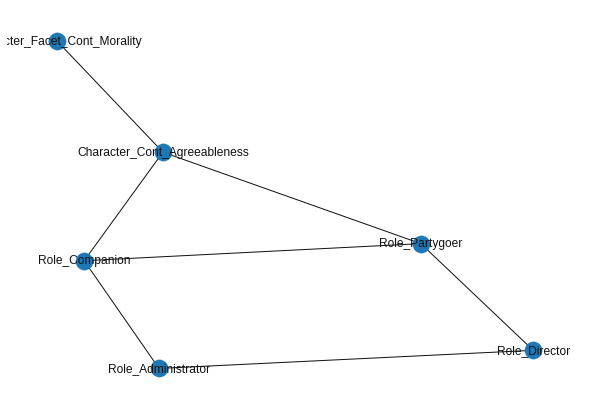

In [ ]:
# Create a network graph to visualize the high correlation features
G = nx.from_pandas_edgelist(net_df)
nx.draw(G, with_labels = True)

From the network graph above we could see that Character_Cont_Agreeableness should be removed from the features.

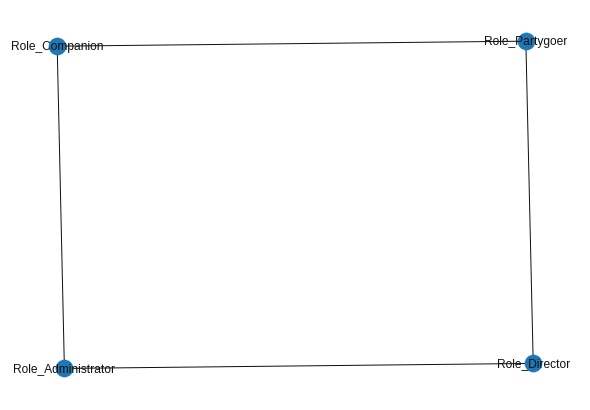

In [ ]:
# Update network graph
net_df = net_df.loc[net_df["source"] != "Character_Cont_Agreeableness", :]
net_df = net_df.loc[net_df["target"] != "Character_Cont_Agreeableness", :]
G = nx.from_pandas_edgelist(net_df)
nx.draw(G, with_labels = True)

From the network above we could see that we need to removed either Role_Partgoer and Role_Administrator or Role_Director and Role_Companion. To remove which of those features from the data, we need to check its spearman correlation coefficient and remove two of the highest correlation.

In [ ]:
temp = X.corr(method = "spearman")

# Role_Director - Role_Partygoer
print(temp.loc["Role_Director", "Role_Partygoer"])

# Role_Director - Role_Administrator
print(temp.loc["Role_Director", "Role_Administrator"])

# Role_Partygoer - Role_Companion
print(temp.loc["Role_Partygoer", "Role_Companion"])

# Role Administrator - Role_Companion
print(temp.loc["Role_Administrator", "Role_Companion"])

0.739028413942745
0.7404701241533898
0.8725524998833905
0.7954731569368192


From the coefficient correlation above we could conclude that Role_Partygoer and Role_Administrator should be removed from the features.

In [ ]:
# Update features
X = X.drop(["Role_Partygoer", "Role_Administrator", "Character_Cont_Agreeableness"], axis = 1)

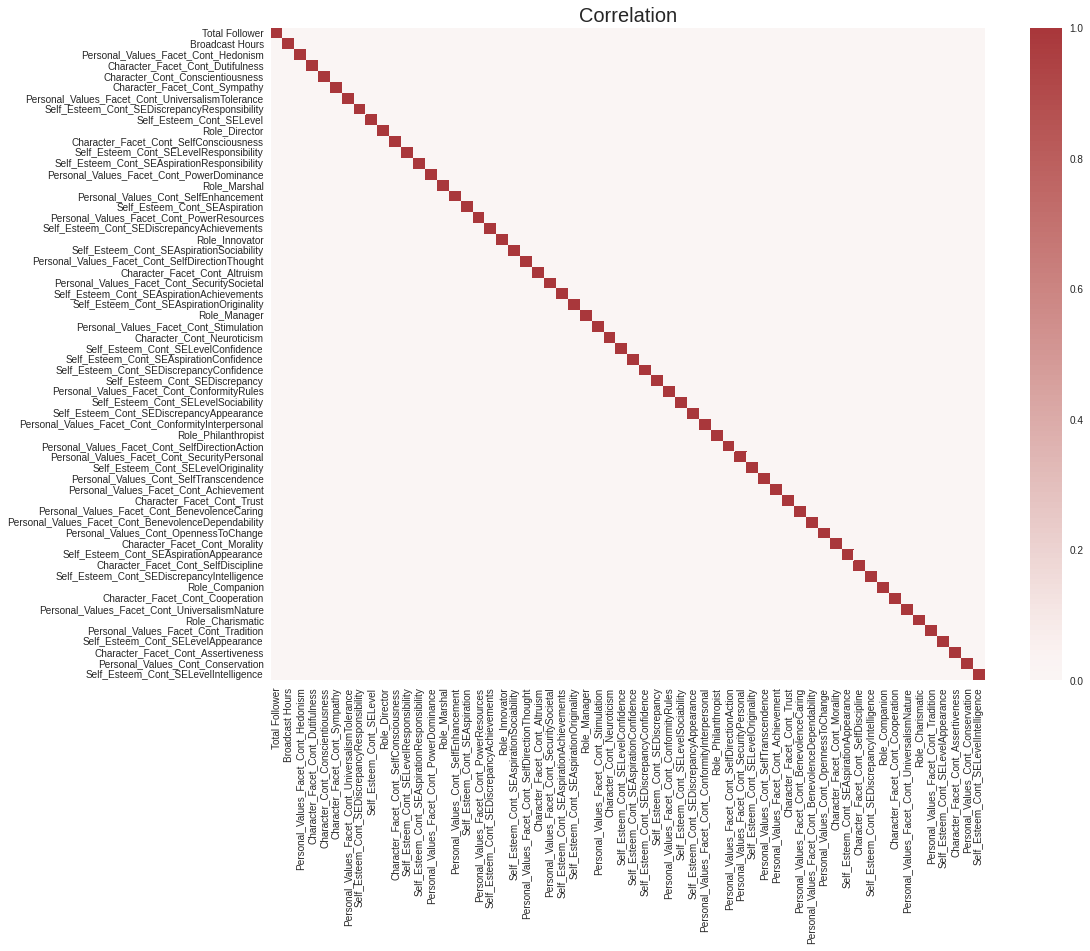

In [ ]:
# Confirm if there is still multicollinearity between numerical features
temp = X.loc[:, [i for i in X.columns if i not in cat_dummy_df.columns]]

plt.figure(figsize = (16,12))

# High correlation: |Coefficient Correlation| >= 0.7
sns.heatmap(abs(temp.corr(method = "spearman")) >= 0.7, vmin = 0, vmax = 1, center = 0, cmap = "vlag")
plt.title("Correlation", fontsize = 20)
plt.show()

Now, there is no multicollinearity in our numerical features.

## Split Data and Feature Scaling

In [ ]:
# Split data into training and testing data with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
# Create a function for scaling with normalization techniques
def feature_scaling(Xtrain_data, Xtest_data, dummy_var, scaling = "normalization"):
  if scaling == "normalization":
    scaler = MinMaxScaler()
  elif scaling == "standardization":
    scaler = StandardScaler()

  # Fit our scaler instance into the data
  scaler = scaler.fit(Xtrain_data.drop(dummy_var, axis = 1))

  # Train Data
  Xtrain_norm = scaler.transform(Xtrain_data.drop(dummy_var, axis = 1))
  Xtrain_norm = pd.DataFrame(Xtrain_norm)
  Xtrain_norm.columns = [i for i in Xtrain_data.columns if i not in dummy_var]

  # Testing
  Xtest_norm = scaler.transform(Xtest_data.drop(dummy_var, axis = 1))
  Xtest_norm = pd.DataFrame(Xtest_norm)
  Xtest_norm.columns = [i for i in Xtest_data.columns if i not in dummy_var]

  Xtrain_data = pd.concat([Xtrain_data[dummy_var], Xtrain_norm.set_index(Xtrain_data.index)],
                          axis = 1)
  Xtest_data = pd.concat([Xtest_data[dummy_var], Xtest_norm.set_index(Xtest_data.index)],
                         axis = 1)
  
  return scaler, Xtrain_data, Xtest_data

In [ ]:
# Features scaling
dummy_columns = [i for i in X_train.columns if i in cat_dummy_df.columns]
feature_scaler, X_train, X_test = feature_scaling(X_train, X_test, dummy_columns)

### Re-do the feature scaling to save its feature scaler based on the only important features

Run this, if only needed!

In [ ]:
# # First, we need to re-run the split code block to retain our original X_train
# # Before it gets feature scaling

# # Save the X_train that only has significant features
# X_train_num_sig = X_train.drop(unsignificant_features, axis = 1).iloc[:, 4:]
# X_train_num_sig.head()

,Character_Facet_Cont_Dutifulness,Character_Facet_Cont_Morality,Self_Esteem_Cont_SEDiscrepancyIntelligence
442,0.494870,0.200416,0.481978
42,0.359154,0.149559,0.494643
58,0.507368,0.227554,0.490817
481,0.608200,0.136880,0.481498
78,0.414724,0.395245,0.463630


In [ ]:
# # Save our scaler
# scaler = MinMaxScaler()
# scaler = scaler.fit(X_train_num_sig)
# pickle.dump(scaler, open("/content/drive/MyDrive/Personal Project/MainGames Case Problem/scaler.pkl", "wb"))

## Fitting Supervised Machine Learning Models

### Linear Regression

In [ ]:
# Fit linear regression into the training data
regressor = sm.OLS(y_train, X_train)
result = regressor.fit()
print(result.summary())

                              OLS Regression Results                              
Dep. Variable:     PaidStarPerWatchedHour   R-squared:                       0.305
Model:                                OLS   Adj. R-squared:                  0.174
Method:                     Least Squares   F-statistic:                     2.327
Date:                    Fri, 28 Jan 2022   Prob (F-statistic):           6.78e-07
Time:                            06:25:46   Log-Likelihood:                 1909.8
No. Observations:                     404   AIC:                            -3690.
Df Residuals:                         339   BIC:                            -3430.
Df Model:                              64                                         
Covariance Type:                nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

We could do some backward elimination to reduce the number of features and get the best linear regression model.

In [ ]:
# Backward Elimination function
def backward_elimination(y_train, X_train, alpha = 0.05):
  regressor_bw = sm.OLS(y_train, X_train).fit()
  
  # Unsignificant: p-values > alpha
  if max(regressor_bw.pvalues) > alpha:
    most_unsignificant = True
  else:
    most_unsignificant = False
  
  # Drop feature that has the most unsignificant p-values
  unsignificant_features = []
  while most_unsignificant:
    unsignificant_features.append(regressor_bw.pvalues[regressor_bw.pvalues == max(regressor_bw.pvalues)].index[0])

    regressor_bw = sm.OLS(y_train, X_train.drop(unsignificant_features, axis = 1)).fit()
    
    if max(regressor_bw.pvalues) > 0.05:
      most_unsignificant = True
    else:
      most_unsignificant = False
    
  print(regressor_bw.summary())

  return unsignificant_features

In [ ]:
# Applying backward elimination
unsignificant_features = backward_elimination(y_train, X_train)

                                   OLS Regression Results                                  
Dep. Variable:     PaidStarPerWatchedHour   R-squared (uncentered):                   0.641
Model:                                OLS   Adj. R-squared (uncentered):              0.634
Method:                     Least Squares   F-statistic:                              101.1
Date:                    Fri, 28 Jan 2022   Prob (F-statistic):                    3.33e-84
Time:                            06:25:47   Log-Likelihood:                          1882.5
No. Observations:                     404   AIC:                                     -3751.
Df Residuals:                         397   BIC:                                     -3723.
Df Model:                               7                                                  
Covariance Type:                nonrobust                                                  
                                                 coef    std err          t     

Now, all of our features has significant effect to the target variable. We'll also use these features for another modeling using Random Forest.

The residuals of our estimated model are not normally distributed based on the Jarque-Bera normality test because the Prob(JB) is less than the 5% significance level.

In [ ]:
# Update the regressor based on the significant features
regressor = sm.OLS(y_train, X_train.drop(unsignificant_features, axis = 1)).fit()

In [ ]:
# Checking multicolinierity using VIF
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.drop(unsignificant_features, axis = 1).columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.drop(unsignificant_features, axis = 1), i) for i in range(len(vif_data))]

print(vif_data)

                                      feature       VIF
0                               Gender_Female  2.561830
1                                  Country_PH  1.479533
2              Game_Free Fire - Battlegrounds  1.248522
3                                   Game_PUBG  1.352796
4            Character_Facet_Cont_Dutifulness  9.390069
5               Character_Facet_Cont_Morality  8.554477
6  Self_Esteem_Cont_SEDiscrepancyIntelligence  4.692031


There is no multicollinearity in our estimated model because all the VIF is less than 10.

In [ ]:
# Check for homoscedasticity
_, pval, __, f_pval = het_breuschpagan(regressor.resid, X_train.drop(unsignificant_features, axis = 1))
pval, f_pval

(2.2363451206432484e-25, 7.74087422719197e-30)

Our model does not fulfill the homoscedasticity assumption. As you can see that the p-value is less than the 5% significance level.

In [ ]:
# Autocorrelation test
_, pval, __, f_pval = acorr_breusch_godfrey(regressor)
pval, f_pval

(0.8973848439167075, 0.9360006236672312)

There is no autocorrelation in our estimated model, it means that each streamer is independent of the others. It is concluded from the p-value that is greater than the 5% significance level.

From all of this assumption checking, we can conclude that our linear regression model is not valid for inferencing purposes because there are some assumptions that are not fulfilled. So, we cannot generate valid insights from the test for each regression coefficient.

In [ ]:
# Create a function to calculate the prediction performance using RMSE, MAE, and MAPE
def pred_performance(model, y_true, X):
  # Model must be already fitted
  y_pred = model.predict(X)
  print("RMSE :", mean_squared_error(y_true, y_pred, squared = False))
  print("MAE :", mean_absolute_error(y_true, y_pred))
  print("MAPE :", mean_absolute_percentage_error(y_true, y_pred))

In [ ]:
# Calculate the prediction performance for training data
pred_performance(regressor, y_train, X_train.drop(unsignificant_features, axis = 1))

RMSE : 0.00229147336831861
MAE : 0.0018003468199106567
MAPE : 2.882034038984864


In [ ]:
# Calculate the prediction performance for test data
pred_performance(regressor, y_test, X_test.drop(unsignificant_features, axis = 1))

RMSE : 0.002597812842187091
MAE : 0.0020552717428069696
MAPE : 2.2799998231808063


From the prediction performance metrics we could say that linear regression model has a good performance for predicting PaidStarPerWatchedHour.

#### Linear Regression K-Fold CV

In [ ]:
# Update the features
X = X.drop(unsignificant_features, axis = 1)
X.head()

,Gender_Female,Country_PH,Game_Free Fire - Battlegrounds,Game_PUBG,Character_Facet_Cont_Dutifulness,Character_Facet_Cont_Morality,Self_Esteem_Cont_SEDiscrepancyIntelligence
0,0,0,0,0,0.471456,0.553544,0.473907
1,0,0,0,0,0.493514,0.352700,0.482889
2,1,0,1,0,0.472405,0.657773,0.354271
3,0,0,0,0,0.467787,0.155550,0.481676
4,0,0,1,0,0.583099,0.346318,0.233880


In [ ]:
# Update dummy column
dummy_columns = [i for i in dummy_columns if i in X.columns]
dummy_columns

['Gender_Female', 'Country_PH', 'Game_Free Fire - Battlegrounds', 'Game_PUBG']

In [ ]:
# K-Fold Cross  function
def kfold_cv(Xdata, ydata, split, dummy_var, scale_type = "normalization", model = "LinearRegression"):
  rmse = []
  mae = []
  mape = []
  
  kfold_generator = KFold(n_splits = split)

  for train, test in kfold_generator.split(Xdata, ydata):
    Xtrain_fold = Xdata.iloc[train, :]
    ytrain_fold = ydata[train]
    Xtest_fold = Xdata.iloc[test, :]
    ytest_fold = ydata[test]

    Xtrain_fold, Xtest_fold = feature_scaling(Xtrain_fold, Xtest_fold, dummy_var)

    if model == "LinearRegression":
      model = sm.OLS(ytrain_fold, Xtrain_fold).fit()
    elif model == "RandomForest":
      model = RandomForestRegressor(random_state = 0).fit(Xtrain_fold, ytrain_fold)

    ypred_fold = model.predict(Xtest_fold)
    rmse.append(mean_squared_error(ytest_fold, ypred_fold, squared = False))
    mae.append(mean_absolute_error(ytest_fold, ypred_fold))
    mape.append(mean_absolute_percentage_error(ytest_fold, ypred_fold))
  
  result = {
      "RMSE": rmse,
      "MAE": mae,
      "MAPE": mape
  }
  return result

In [ ]:
# Call the kfold cv function
kfold_cv_result = kfold_cv(X, y, 5, dummy_columns)

# printing result
for i, val in kfold_cv_result.items():
  print(i)
  print("Result for each cv =", val)
  print("Mean =", sum(val)/len(val))
  print()

RMSE
Result for each cv = [0.0022238474805650224, 0.0022793004903164773, 0.002902639179473447, 0.0022968530748672354, 0.001993669492322277]
Mean = 0.0023392619435088917

MAE
Result for each cv = [0.001781857022201186, 0.0018117290936401733, 0.002402477295422034, 0.0018136573507050735, 0.001594924240574082]
Mean = 0.0018809290005085098

MAPE
Result for each cv = [1.8631463309406695, 2.1163756721653657, 4.499873194356209, 2.440379406937216, 3.632435486842441]
Mean = 2.9104420182483803



### Random Forest

In [ ]:
# Fit the model
regressor = RandomForestRegressor(random_state = 0)
regressor.fit(X_train.drop(unsignificant_features, axis = 1), y_train)

# Calculate the prediction performance for training data
pred_performance(regressor, y_train, X_train.drop(unsignificant_features, axis = 1))

RMSE : 0.0012220364079748725
MAE : 0.0008669598131014869
MAPE : 1.248344417674542


In [ ]:
# Calculate the prediction performance for test data
pred_performance(regressor, y_test, X_test.drop(unsignificant_features, axis = 1))

RMSE : 0.0027189826102248815
MAE : 0.002066921144128861
MAPE : 2.435658174839258


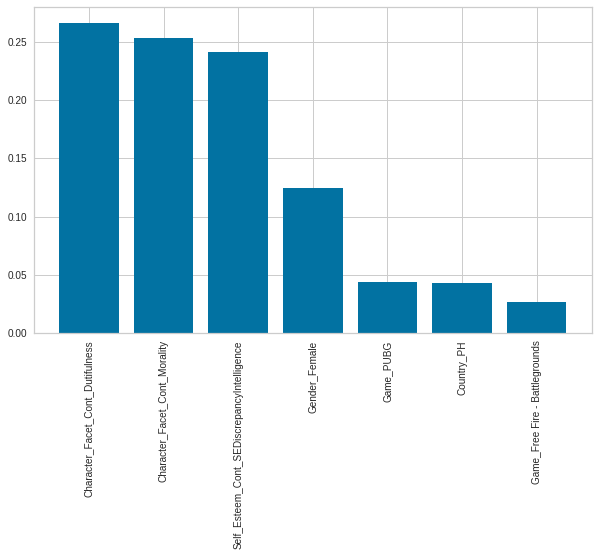

In [ ]:
# Create a dataframe for feature importance values
importance = pd.DataFrame({
    "feature": X_train.drop(unsignificant_features, axis = 1).columns,
    "importance": regressor.feature_importances_
})

# plot feature importance
plt.figure(figsize = (10, 6))
plt.bar(importance.sort_values("importance", ascending = False)["feature"], 
        importance.sort_values("importance", ascending = False)["importance"])
plt.xticks(rotation = 90)
plt.show()

The three most important features are Character_Facet_Cont_Dutifulness, Character_Facet_Cont_Morality, and Self_Esteem_Cont_SEDiscrepancyIntelligence.

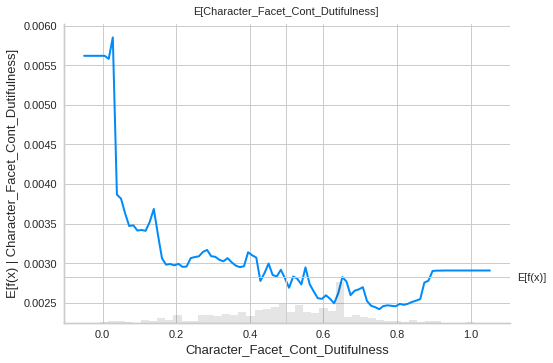

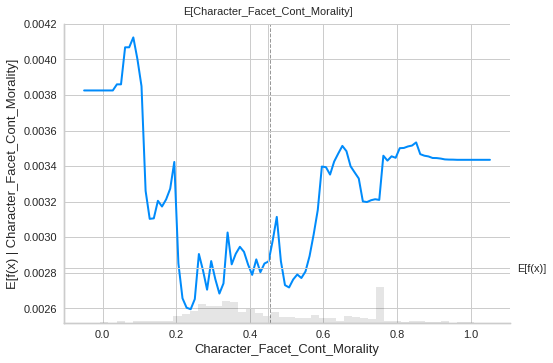

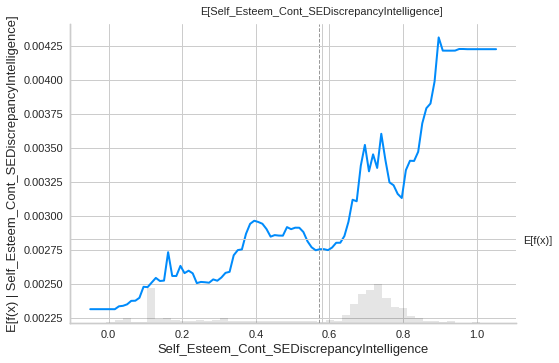

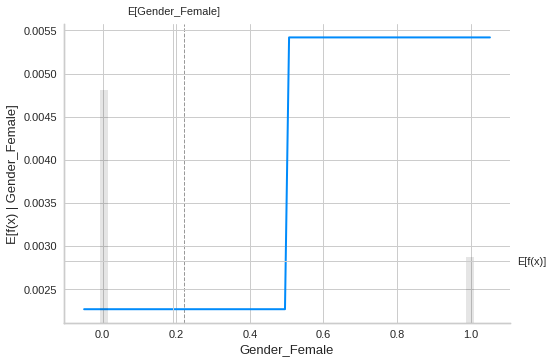

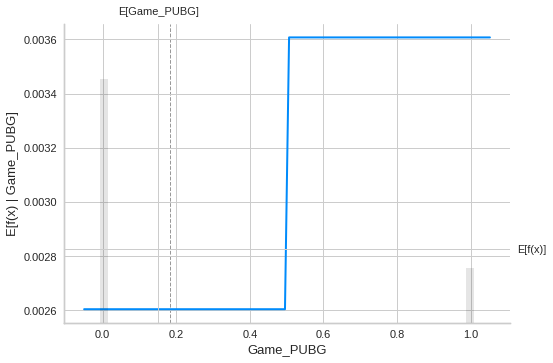

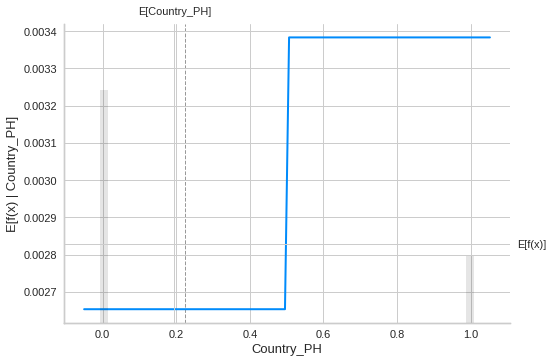

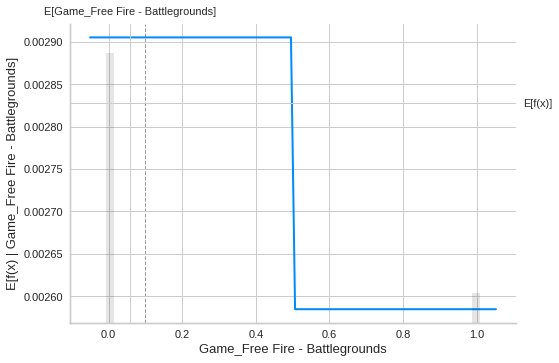

In [ ]:
# Create a dependence plot for each features for random forest regression
for i in importance.sort_values("importance", ascending = False)["feature"]:
  shap.plots.partial_dependence(
      i, regressor.predict, X_train.drop(unsignificant_features, axis = 1), 
      ice=False, model_expected_value=True, feature_expected_value=True
  )

We can generate insights from these dependence plots for each of the feature to optimize streamers revenue based on PaidStarPerWatchedHour.

1. Character_Facet_Cont_Dutifulness has a relatively negative trend with some fluctuations in its partial dependence plot. Therefore, streamers that has highly Character_Facet_Cont_Dutifulness will likely to have lower PaidStarPerWatchedHour. We can also say that Character_Facet_Cont_Dutifulness has a negative effect to the PaidStarPerWatchedHour. Mathematically, we can suggest streamers to get Character_Facet_Cont_Dutifulness to be less than 0.4 in a normalized scale.

2. Character_Facet_Cont_Morality has highly fluctuating patterns in its partial dependence plot and is somewhat quadratic (if we smoothed it). As you can see when its value is less than 0.2 or higher than 0.58 (estimate number) the PaidStarPerWatchedHour is likely to be higher. Therefore, streamers need to consider their approach to get Character_Facet_Cont_Morality to be much lower or higher. They need to decide which one best fits them.

3. Self_Esteem_Cont_SEDiscrepancyIntellgigence has a relatively positive trend with some fluctuations in its partial dependence plot. It also means that Self_Esteem_Cont_SEDiscrepancyIntelligence is likely to have a positive effect on PaidStarPerWatchedHour. Therefore, we can suggest that streamers need to consider getting Self_Esteem_Cont_SEDiscrepancyIntelligence to be higher than 0.65 to get higher PaidStarPerWatchedHour.

4. For the dummy variables, only Game_Free Fire - Battlegrounds has a negative effect on PaidStarPerWatchedHour. Therefore, streamers should choose another game besides Free Fire - Battlegrounds to boost their PaidStarPerWatchedHour. Furthermore, we can suggest they play PUBG rather than Free Fire - Battlegrounds on their stream play.

#### Random Forest K-Fold CV

In [ ]:
# Call the kfold cv function
kfold_cv_result = kfold_cv(X, y, 5, dummy_columns, model = "RandomForest")

# printing result
for i, val in kfold_cv_result.items():
  print(i)
  print("Result for each cv =", val)
  print("Mean =", sum(val)/len(val))
  print()

RMSE
Result for each cv = [0.002386292042889207, 0.001737592763192836, 0.0025482846373466013, 0.0019447253894309224, 0.0017843341798309317]
Mean = 0.0020802458025380994

MAE
Result for each cv = [0.0018552585384132797, 0.0013498884774112646, 0.0019759445296945494, 0.0015354076598476077, 0.0014265462887694804]
Mean = 0.0016286090988272364

MAPE
Result for each cv = [1.871866786326049, 1.7972728556224886, 2.529659515749565, 2.486474580231056, 2.929108732216749]
Mean = 2.3228764940291815



We can conclude that Random Forest regression has better performance to predict PaidStarWatchedPerHour than the linear regression model. Furthermore, we can do hyperparameter tuning to get the best model for our Random Forest regression. We will use the GridSearch technique for this hyperparameter tuning.

#### Random Forest Hyperparameter Tuning

GridSearchCV implementation

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
regressor = RandomForestRegressor(random_state = 0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train.drop(unsignificant_features, axis = 1), y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [ ]:
# Print the best parameters for our Random Forest regression model
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [ ]:
# Calculate the prediction performance for test data
pred_performance(grid_search.best_estimator_, y_test, X_test.drop(unsignificant_features, axis = 1))

RMSE : 0.002619039957119687
MAE : 0.0020614435843609234
MAPE : 2.431578367731409


Now you can see that our model has better performance to predict the test data. Then, we can save our model.

In [ ]:
# Save model
pickle.dump(grid_search.best_estimator_, open('/content/drive/MyDrive/Personal Project/MainGames Case Problem/RFModel.pkl', 'wb'))

We can create a web app using the streamlit framework to interactively predict the PaidStarPerWatchedHour based on its important features from our saved model above.

## Unsupervised Machine Learning using K-Means

In [ ]:
# Merge train and test data
X_new = pd.concat([X_train.drop(unsignificant_features, axis = 1), 
                   X_test.drop(unsignificant_features, axis = 1)]).reset_index(drop = True)
y_new = pd.concat([y_train, y_test]).reset_index(drop = True)
df_new = pd.concat([X_new, y_new], axis = 1)
df_new

,Gender_Female,Country_PH,Game_Free Fire - Battlegrounds,Game_PUBG,Character_Facet_Cont_Dutifulness,Character_Facet_Cont_Morality,Self_Esteem_Cont_SEDiscrepancyIntelligence,PaidStarPerWatchedHour
0,0,0,0,0,0.514680,0.244995,0.719922,0.000102
1,0,0,0,0,0.286418,0.182825,0.761937,0.002320
2,0,0,0,0,0.535701,0.278169,0.749245,0.000858
3,0,0,0,0,0.705291,0.167327,0.718332,0.000491
4,0,0,0,0,0.379882,0.483160,0.659058,0.000110
...,...,...,...,...,...,...,...,...
500,0,0,0,1,0.545369,0.602229,0.008008,0.001082
501,1,0,0,0,0.545485,0.567108,0.211293,0.005738
502,0,1,0,0,0.679213,0.250741,0.766538,0.000334
503,1,0,0,0,0.128054,0.810485,0.316456,0.009030


### Finding the Best Number of Clusters

#### Elbow Method

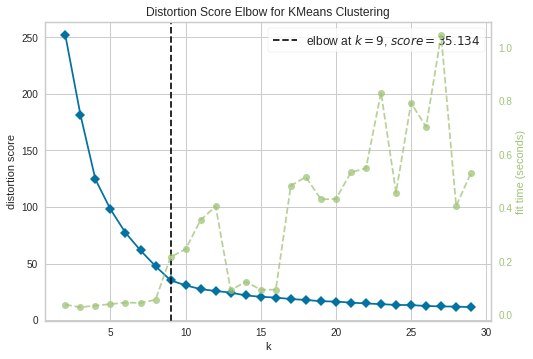

In [ ]:
# Using yellowbrick package

kmeans = KMeans()
# k is range of number of clusters
visualizer = KElbowVisualizer(kmeans, k = (2, 30), timings = True)
visualizer.fit(df_new)
visualizer.show()

Text(0, 0.5, 'WCSS')

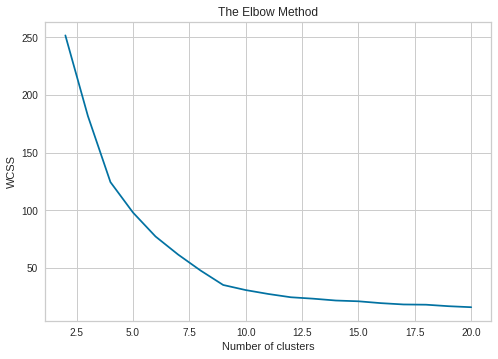

In [ ]:
# Calculate manually

# Choosing the best number of clusters using elbow method
wcss=[]
max = 20
for i in range(2, max + 1):
  kmeans = KMeans(i)
  kmeans.fit(df_new)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(2, max + 1)

plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Nine Clusters is the best number of clusters based on the elbow method.

#### Silhouette Method

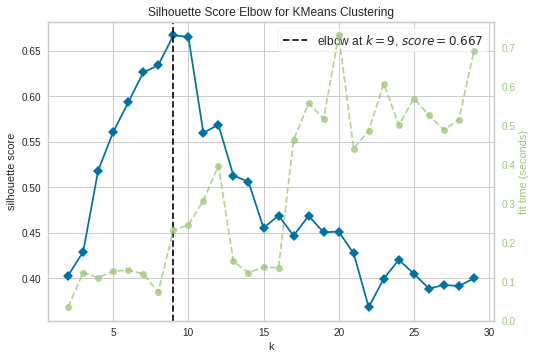

In [ ]:
# Using yellowbrick package

kmeans = KMeans()
# k is range of number of clusters
visualizer = KElbowVisualizer(kmeans, k = (2, 30), metric = 'silhouette', timings = True)
visualizer.fit(df_new)
visualizer.show()

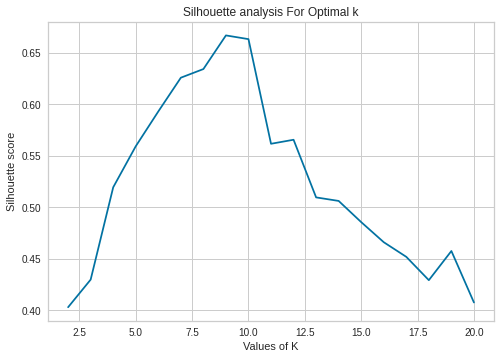

In [ ]:
# Calculate manually

max = 20
range_n_clusters = range(2, max + 1)
silhouette_avg = []

for num_clusters in range_n_clusters:
 # initialise kmeans
 kmeans = KMeans(n_clusters = num_clusters)
 kmeans.fit(df_new)
 cluster_labels = kmeans.labels_
 # silhouette score
 silhouette_avg.append(silhouette_score(df_new, cluster_labels))
 
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

Nine Clusters is the best number of clusters based on the silhouette method.

In [ ]:
# K-Means clustering for 9 clusters
kmeans = KMeans(9)
kmeans.fit(df_new)

KMeans(n_clusters=9)

In [ ]:
# Check the center of each clusters
cluster_center = {}

for ind, val in enumerate(kmeans.cluster_centers_):
  cluster_center["Cluster" + str(ind + 1)] = list(map(lambda x: round(x, 3), val))

cluster_center = pd.DataFrame(cluster_center)
cluster_center.index = df_new.columns
cluster_center

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6,Cluster7,Cluster8,Cluster9
Gender_Female,1.000,-0.000,-0.000,1.000,-0.000,-0.000,1.000,1.000,-0.000
Country_PH,0.000,0.000,-0.000,-0.000,1.000,-0.000,1.000,0.000,-0.000
Game_Free Fire - Battlegrounds,1.000,-0.000,-0.000,-0.000,-0.000,1.000,0.000,0.000,-0.000
Game_PUBG,0.000,0.000,1.000,-0.000,0.036,-0.000,0.000,1.000,-0.000
Character_Facet_Cont_Dutifulness,0.564,0.485,0.460,0.594,0.440,0.466,0.576,0.625,0.617
Character_Facet_Cont_Morality,0.711,0.334,0.404,0.719,0.370,0.419,0.701,0.680,0.735
Self_Esteem_Cont_SEDiscrepancyIntelligence,0.229,0.720,0.635,0.214,0.710,0.660,0.266,0.264,0.118
PaidStarPerWatchedHour,0.003,0.002,0.003,0.005,0.003,0.002,0.005,0.005,0.002


We can use this cluster to effectively targeting our strategic approach to the right streamers to increase their revenues by increasing its PaidStarPerWatchedHour.

### PCA Plot to Visualize Cluster

In [ ]:
# Create a PCA instance for the first two components
pca = PCA(2, random_state = 1)

# Fit the data
principalComponents = pca.fit_transform(df_new)

In [ ]:
# Change the principal component results into data frame
principalComponents = pd.DataFrame(principalComponents)
principalComponents

,0,1
0,-0.302783,-0.069353
1,-0.371951,-0.064604
2,-0.302198,-0.069057
3,-0.303601,-0.073347
4,-0.212762,-0.066752
...,...,...
500,0.122719,-0.684885
501,0.843024,0.002737
502,-0.380460,0.720111
503,0.823474,0.013678


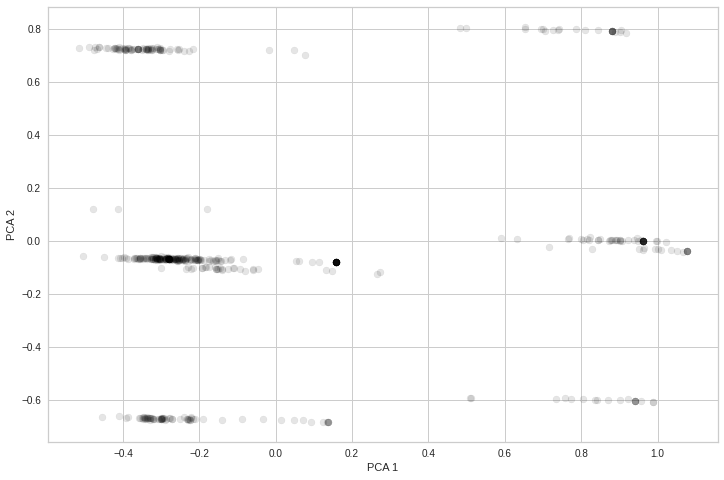

In [ ]:
# Plot the first two of principal components
plt.figure(figsize = (12, 8))
plt.scatter(principalComponents[0], principalComponents[1], alpha=.1, color = 'black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [ ]:
# Prepare the data to visualize the cluster
df_cluster = pd.concat([principalComponents, pd.Series(kmeans.labels_)], axis = 1)
df_cluster.columns = ["PCA1", "PCA2", "Cluster"]
df_cluster

,PCA1,PCA2,Cluster
0,-0.302783,-0.069353,1
1,-0.371951,-0.064604,1
2,-0.302198,-0.069057,1
3,-0.303601,-0.073347,1
4,-0.212762,-0.066752,1
...,...,...,...
500,0.122719,-0.684885,2
501,0.843024,0.002737,3
502,-0.380460,0.720111,4
503,0.823474,0.013678,3


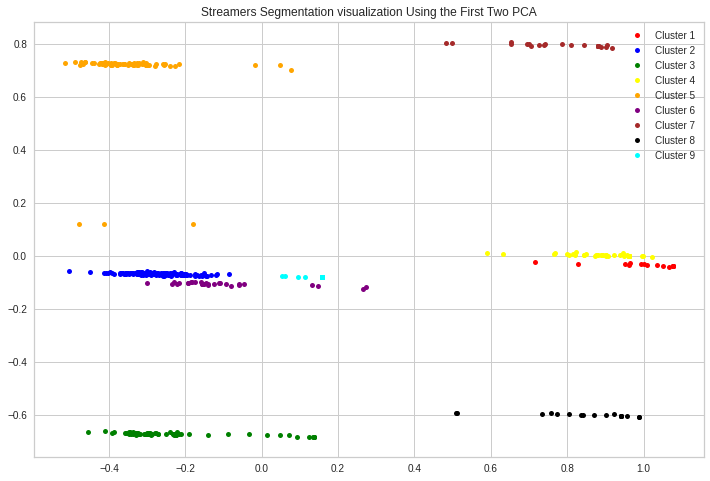

In [ ]:
# Plot the clusters
colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5: 'purple',
          6: 'brown',
          7: 'black',
          8: 'cyan'}

names = {0: 'Cluster 1', 
         1: 'Cluster 2', 
         2: 'Cluster 3', 
         3: 'Cluster 4',
         4: 'Cluster 5',
         5: 'Cluster 6',
         6: 'Cluster 7',
         7: 'Cluster 8',
         8: 'Cluster 9'}

groups = df_cluster.groupby('Cluster')

fig, ax = plt.subplots(figsize=(12, 8)) 

for name, group in groups:
    ax.plot(group.PCA1, group.PCA2, marker='o', linestyle='', ms=5,
            color = colors[name], label = names[name], mec = 'none')
    ax.set_aspect('auto')
    ax.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
    ax.tick_params(axis = 'y', which = 'both', left = 'off', top = 'off', labelleft = 'off')
    
ax.legend()
ax.set_title("Streamers Segmentation visualization Using the First Two PCA")
plt.show()

The plot above is the visualization of the clusters using the first two PCAs for the x and y-axis. As you can see, our clusters don't seem to have good representations of separated data points when we used the first two PCAs as their axes. But if we look carefully, we can see that the clusters are mostly defined horizontal-wise (linearly) rather than oval-shaped except for the fifth cluster.

# Conclusion

Here are our conclusions to answer the main problem statement:

1. There are 7 features that has important effect on PaidStarPerWatchedHour which are: 
  - Gender_Female,
  - Country_PH,
  - Game_Free Fire - Battlegrounds,
  - Game_PUBG,
  - Character_Facet_Cont_Dutifulness,
  - Character_Facet_Cont_Morality, and
  - Self_Esteem_Cont_SEDiscrepancyIntelligence.
2. Features that has positive effect on PaidStarPerWatchedHour are:
  - Gender_Female,
  - Country_PH,
  - Game_PUBG, and
  - Self_Esteem_Cont_SEDiscrepancyIntellgigence.
3. Features that has negative effect on PaidStarPerWatchedHour are:
  - Character_Facet_Cont_Dutifulness, and
  - Game_Free Fire - Battlegrounds.
4. Last but not least, Character_Facet_Cont_Morality has highly fluctuating patterns and is somewhat quadratic.

# Recommendation

For the overall streamers, we can only give recommendations based on the features beside Gender_Female and Country_PH. Below are the recommendations:

1. Game_Free Fire - Battlegrounds and Game_PUBG: Streamers should consider to play games other than Free Fire - Battlegrounds in their streaming. It is also better to play PUBG in their streaming because it has positive effect on their chances to get more PaidStarPerWatchedHour.
2. Self_Esteem_Cont_SEDiscrepancyIntellgigence: Streamers should give "big-brain-move" and high self-esteem while they are playing games in their streaming to confidently show their intelligence to the audience. It will also make the audience more entertained when streamers gave them "wow" moments and they will be amazed at the task that streamers did in the game. Therefore, audience will likely to give streamers more PaidStarPerWatchedHour.
3. Character_Facet_Cont_Dutifulness: Streamers should be more creative in their playing while streaming the game and make it more joyful. This particular approach will make their character facet to be less dutiful (too serious) and make them get more PaidStarPerWatchedHour.
4. Character_Facet_Cont_Morality: Streamers should decide whether they want to act like a bad guy or a good guy in the game to make it more interesting. It will also affect their character facet to support their chances to get more PaidStarPerWatchedHour.

MainGames should give those recommendations to its streamers effectively by elaborating and considering all the 9 clusters that have been generated using K-means clustering as their target. MainGames could also provide platforms for daily recommendations and stats for their streamers based on those features (except for Gender_Female and Country_PH) and tract their effect on the increase of their PaidStarPerWatchedHour. Streamers will use these platforms to evaluate their performance and strategy to make effective streaming gameplay.